In [1]:
# Load library imports
import sys
import joblib
import logging
import pandas as pd

# Load project Imports
from src.utils.config_loader import load_project_config
from src.data_ingestion.gwl_data_ingestion import process_station_coordinates, \
    fetch_and_process_station_data, download_and_save_station_readings
from src.preprocessing.gwl_preprocessing import load_timeseries_to_dict, outlier_detection, \
    resample_daily_average, remove_spurious_data, interpolate_short_gaps, handle_large_gaps

In [2]:
# Set up logging config
logging.basicConfig(
    level=logging.INFO,
   format='%(levelname)s - %(message)s',
#    format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

# Set up logger for file and load config file for paths and params
logger = logging.getLogger(__name__)
config = load_project_config(config_path="config/project_config.yaml")

# Define notebook demo catchment
catchments_to_process = config["global"]["pipeline_settings"]["catchments_to_process"]
catchment = catchments_to_process[0]
run_defra_API_calls = config["global"]["pipeline_settings"]["run_defra_api"]  # True to run API calls

logging.info(f"Notebook Demo Catchment: {catchment}")

INFO - Loading configuration from: /Users/charlotte/Desktop/Dissertation_Code/config/project_config.yaml
INFO - Notebook Demo Catchment: eden


### DATA INGESTION ###

Load gwl station list with grid references and convert grid references to easting, northing, longitude and latitude form for plotting and data alignment.

In [3]:
# --- Process Catchment Stations List ----
stations_with_coords_df = process_station_coordinates(
    os_grid_squares=config["global"]["paths"]["gis_os_grid_squares"],
    station_list_input=config[catchment]["paths"]["gwl_station_list"],
    station_list_output=config[catchment]["paths"]["gwl_station_list_with_coords"],
    catchment=catchment
)

logger.info(f"Pipeline step 'Process Station Coordinates for {catchment}' complete.\n")

INFO - [eden] Starting coordinate processing for station list...

INFO - [eden] Loaded OS grid squares lookup from: data/01_raw/global/os_grid_squares.csv
INFO - [eden] Loaded station list from: data/01_raw/eden/gwl_stations/station_list.csv
INFO - [eden] Converted OS grid references to coordinates for 17 stations.

INFO - [eden] Saved processed station list to: data/02_processed/eden/gwl_station_data/station_list_with_coords.csv
INFO - Station location reference table head:

  station_id    station_name    grid_ref   easting  northing        lat  \
0     NY36_2        longtown  NY39146790  339140.0  567900.0  55.001931   
1     NY46_3         scaleby  NY46526426  346520.0  564260.0  54.970074   
2    NY55_71  castle_carrock  NY53825337  353820.0  553370.0  54.872953   
3    NY54_54         croglin  NY56354839  356350.0  548390.0  54.828432   
4    NY54_10       ainstable  NY52574645  352570.0  546450.0  54.810655   

        lon  
0 -2.952971  
1 -2.836931  
2 -2.721158  
3 -2.680981 

**API Documentation notes:**

1. The API calls that return readings data have a soft limit of 100,000 rows per-call which can be overridden by setting a _limit parameter. There is a hard limit of 2,000,000 rows, which cannot be overridden.
2. The primary identifier for most stations uses a GUID style identifier called an SUID. These are used in the URL for the station and given as the value of the notation property in the station metadata.  
    a. Wiski identifier (wiskiID) is also available for my subset of stations and data type  
3. All monitoring stations can be filtered by name, location and other parameters. See https://environment.data.gov.uk/hydrology/doc/reference#stations-summary for full metadata details

In [4]:
if run_defra_API_calls:
    # Retrieve gwl monitoring station metadata and measures from DEFRA API
    stations_with_metadata_measures = fetch_and_process_station_data(
        stations_df=stations_with_coords_df,
        base_url=config["global"]["paths"]["defra_station_base_url"],
        output_path=config[catchment]["paths"]["gwl_station_metadata_measures"]
    )

    logger.info(f"Pipeline step 'Pull Hydrological Station Metadata for {catchment}' complete.\n")

    stations_with_metadata_measures.head()

In [5]:
if run_defra_API_calls:
    download_and_save_station_readings(
        stations_df=stations_with_metadata_measures,
        start_date=config["global"]["data_ingestion"]["api_start_date"],
        end_date=config["global"]["data_ingestion"]["api_end_date"],
        gwl_data_output_dir=config[catchment]["paths"]["gwl_data_output_dir"]
    )

    logger.info(f"All timeseries groundwater level data saved for {catchment} catchment.")
    
else:
    
    loaded_csv_path = config[catchment]["paths"]["gwl_station_metadata_measures"]
    stations_with_metadata_measures = pd.read_csv(loaded_csv_path)

### PREPROCESSING ###

Remove stations with insufficient data and clean ts data from outliers and incorrect measurements. Interpolate between small data gaps using rational spline.

1. Load station df's into dict, dropping catchments with insufficient data

In [6]:
# Load timeseries CSVs from API into reference dict
gwl_time_series_dict = load_timeseries_to_dict(
    stations_df=stations_with_metadata_measures,
    col_order=config["global"]["data_ingestion"]["col_order"],
    data_dir=config[catchment]["paths"]["gwl_data_output_dir"],
    inclusion_threshold=config[catchment]["preprocessing"]["inclusion_threshold"]
)

logger.info(f"All timeseries data converted to dict for {catchment} catchment.\n")

INFO - Converting API csv data to reference dict...

INFO - Longtown successfully saved to dict.
INFO - Scaleby successfully saved to dict.
INFO - Castle_Carrock successfully saved to dict.
INFO - Croglin successfully saved to dict.
INFO - Ainstable successfully saved to dict.
INFO - Baronwood successfully saved to dict.
INFO - Renwick successfully saved to dict.
INFO - East_Brownrigg successfully saved to dict.
INFO - Bgs_Ev2 successfully saved to dict.
INFO - Station Penrith_North contained insufficient data -> dropping dataframe.(40 < 5000)
INFO - Skirwith successfully saved to dict.
INFO - Cliburn_Town_Bridge_1 successfully saved to dict.
INFO - Cliburn_Town_Bridge_2 successfully saved to dict.
INFO - Hilton successfully saved to dict.
INFO - Coupland successfully saved to dict.
INFO - Great_Musgrave successfully saved to dict.
INFO - East_Curthwaite successfully saved to dict.
INFO - 16 stations saved to dict.

INFO - All timeseries data converted to dict for eden catchment.



2. Remove outlying and incorrect data points

INFO - Station Ainstable: Shifted values by +0.4654 between 2021-06-16 and 2021-11-17.
INFO - Station Ainstable: Inverted segment between 2022-08-01 and 2023-04-18 around mean = 84.7347
INFO - Station Ainstable: Shifted values by +-0.5928 between 2022-08-01 and 2023-04-18.
Removed data for range: 2021-06-13 to 2021-06-17
Removed data for range: 2021-11-15 to 2021-11-19
Removed data for range: 2023-04-16 to 2023-04-20
INFO - Ainstable time series data in daily timestep saved to results/figures/eden/time_series/Ainstable_aggregated_daily.png.

INFO - Station Renwick: Removed 6961 data points between 2023-01-06 and 2023-10-23.
INFO - Renwick time series data in daily timestep saved to results/figures/eden/time_series/Renwick_aggregated_daily.png.



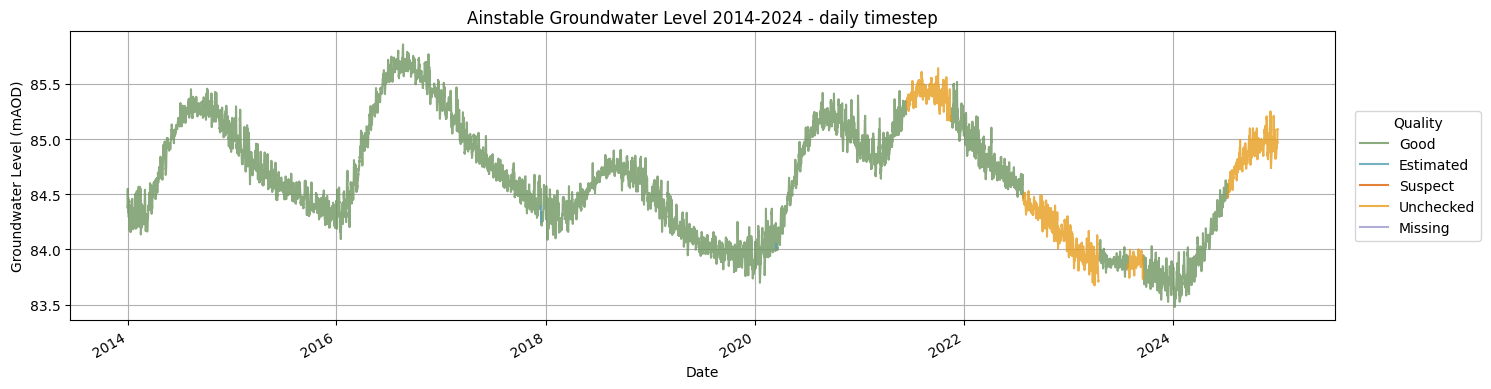

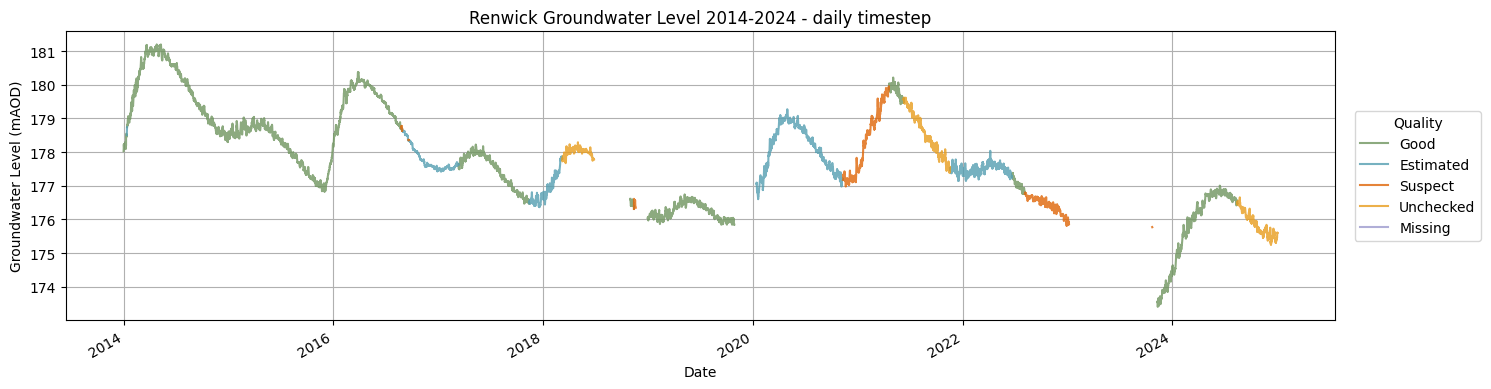

In [7]:
for station_name, df in gwl_time_series_dict.items():
    gwl_time_series_dict[station_name] = remove_spurious_data(
        target_df=df,
        station_name=station_name,
        path=config[catchment]["visualisations"]["ts_plots"]["time_series_gwl_output"],
        notebook=True
    )

INFO - Processing 1 / 16: Longtown...

INFO - No outliers to plot for station Longtown
INFO - Station Longtown: Hard limits 15.17 - 21.11
INFO - Station Longtown: No points out of range.
INFO - Total 0 outliers detected and replaced by Hampel filter in 'Longtown'.
INFO - No outliers to plot for station Longtown
INFO - Processing Longtown complete.



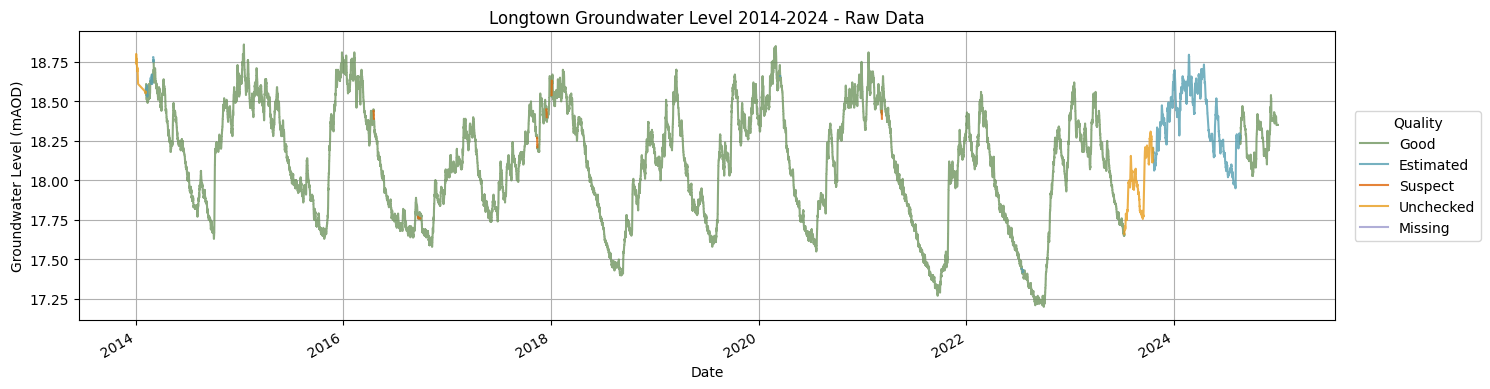

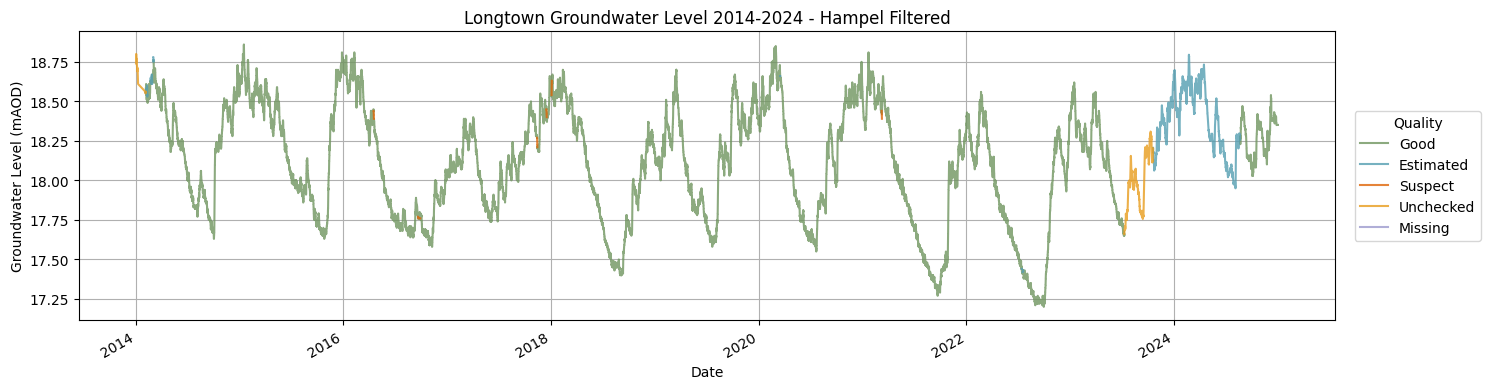

INFO - Processing 2 / 16: Scaleby...

INFO - No outliers to plot for station Scaleby
INFO - Station Scaleby: Hard limits 39.54 - 42.73
INFO - Station Scaleby: Identified 1 points outsideIQR-based range and set to NaN.
INFO - Total 0 outliers detected and replaced by Hampel filter in 'Scaleby'.
INFO - No outliers to plot for station Scaleby
INFO - Processing Scaleby complete.



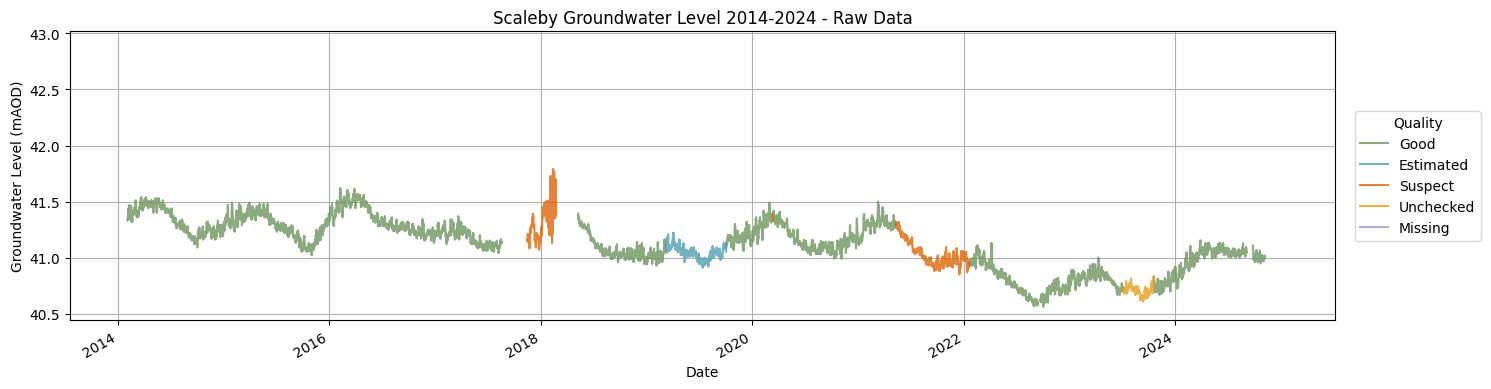

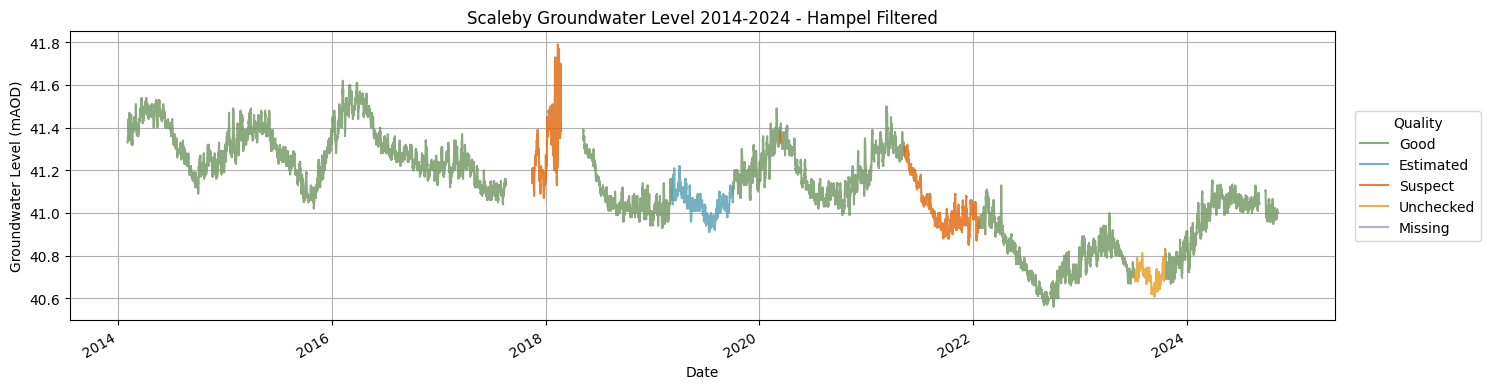

INFO - Processing 3 / 16: Castle_Carrock...

INFO - No outliers to plot for station Castle_Carrock
INFO - Station Castle_Carrock: Hard limits 116.12 - 150.00
INFO - Station Castle_Carrock: No points out of range.
INFO - Total 0 outliers detected and replaced by Hampel filter in 'Castle_Carrock'.
INFO - No outliers to plot for station Castle_Carrock
INFO - Processing Castle_Carrock complete.



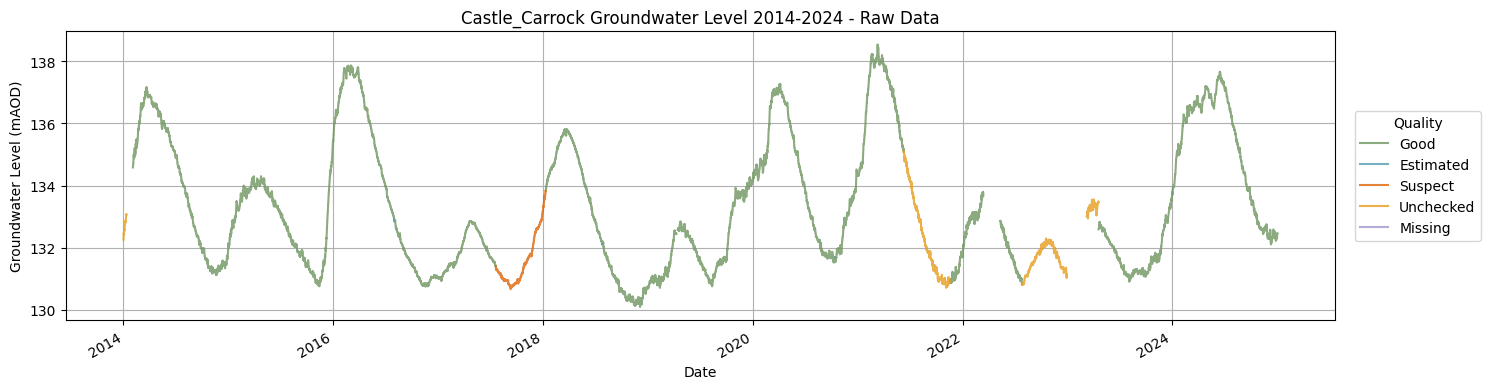

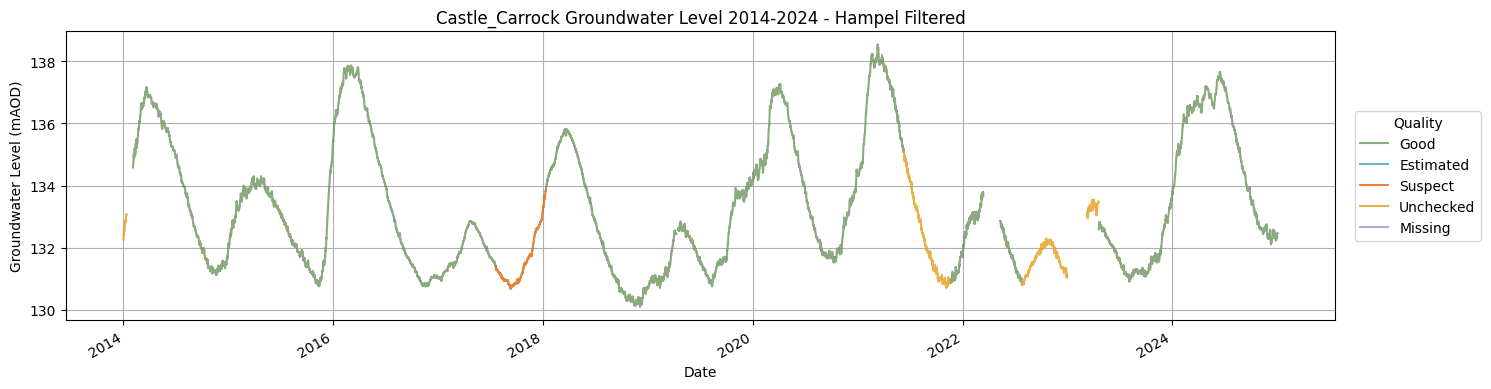

INFO - Processing 4 / 16: Croglin...

INFO - No outliers to plot for station Croglin
INFO - Station Croglin: Hard limits 157.08 - 178.20
INFO - Station Croglin: No points out of range.
INFO - Total 2 outliers detected and replaced by Hampel filter in 'Croglin'.
INFO - Processing Croglin complete.



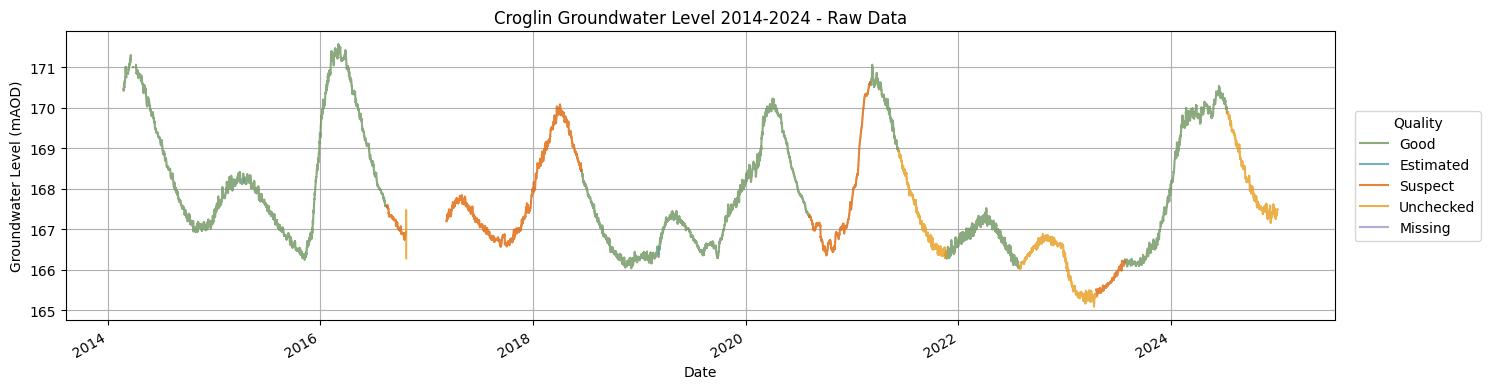

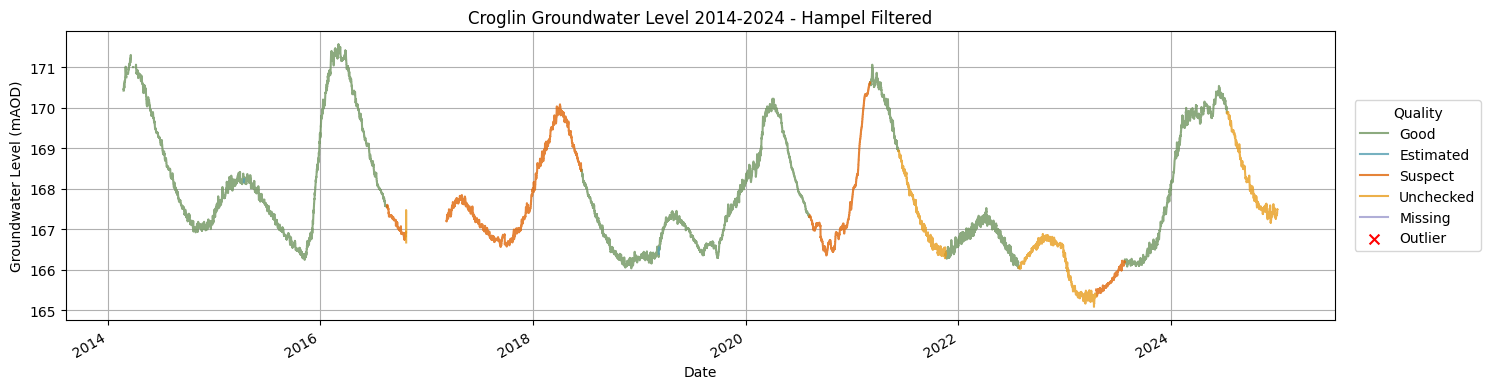

INFO - Processing 5 / 16: Ainstable...

INFO - No outliers to plot for station Ainstable
INFO - Station Ainstable: Hard limits 80.37 - 88.91
INFO - Station Ainstable: No points out of range.
INFO - Total 0 outliers detected and replaced by Hampel filter in 'Ainstable'.
INFO - No outliers to plot for station Ainstable
INFO - Processing Ainstable complete.



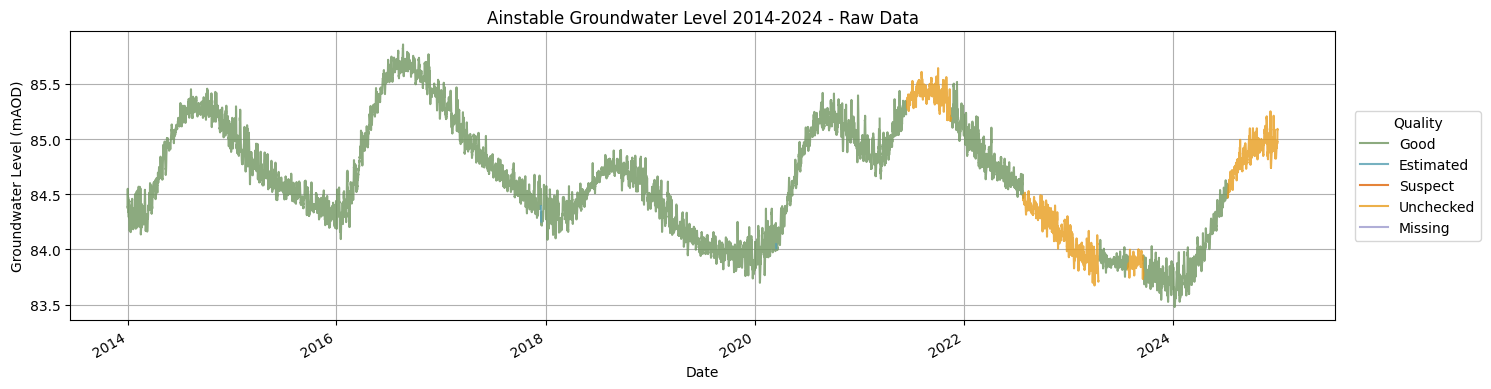

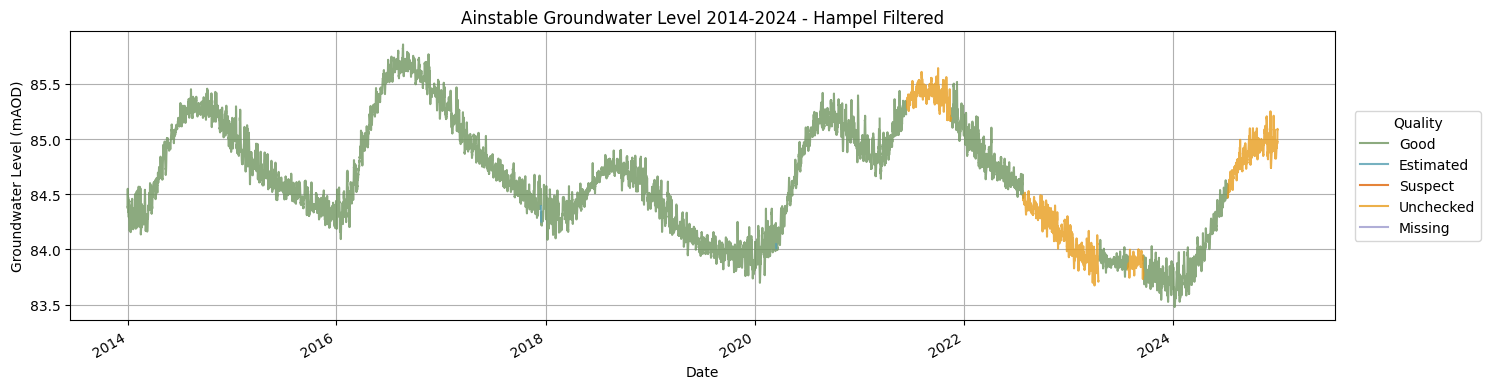

INFO - Processing 6 / 16: Baronwood...

INFO - No outliers to plot for station Baronwood
INFO - Station Baronwood: Hard limits 83.36 - 88.33
INFO - Station Baronwood: No points out of range.
INFO - Total 0 outliers detected and replaced by Hampel filter in 'Baronwood'.
INFO - No outliers to plot for station Baronwood
INFO - Processing Baronwood complete.



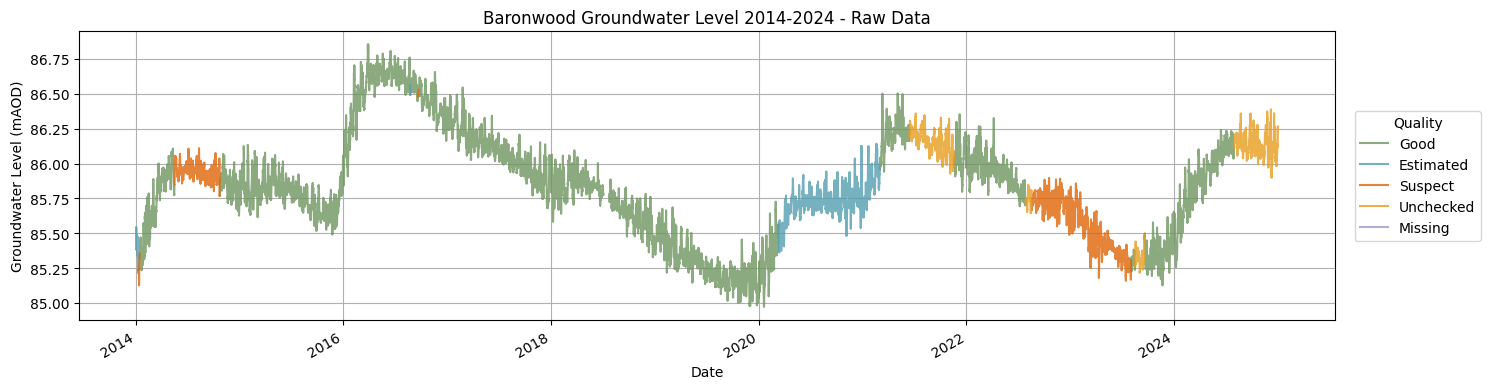

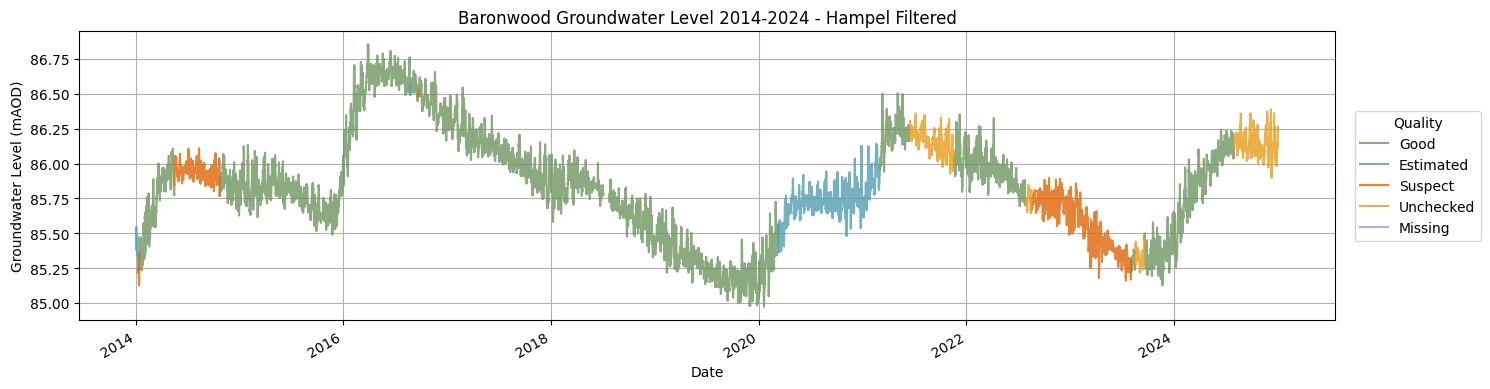

INFO - Processing 7 / 16: Renwick...

INFO - No outliers to plot for station Renwick
INFO - Station Renwick: Hard limits 165.49 - 189.55
INFO - Station Renwick: No points out of range.
INFO - Total 0 outliers detected and replaced by Hampel filter in 'Renwick'.
INFO - No outliers to plot for station Renwick
INFO - Processing Renwick complete.



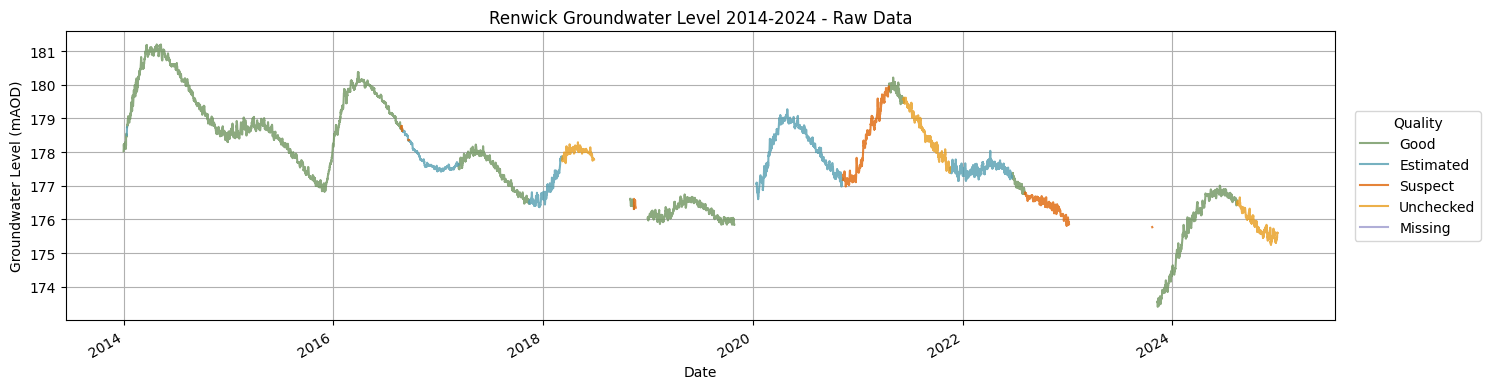

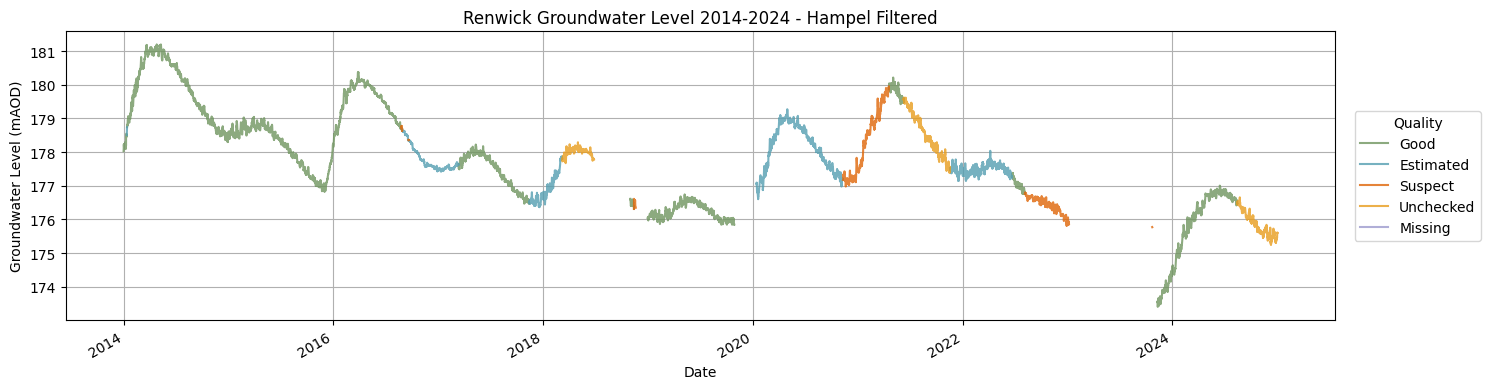

INFO - Processing 8 / 16: East_Brownrigg...

INFO - No outliers to plot for station East_Brownrigg
INFO - Station East_Brownrigg: Hard limits 103.90 - 109.59
INFO - Station East_Brownrigg: Identified 46 points outsideIQR-based range and set to NaN.
INFO - Total 1 outliers detected and replaced by Hampel filter in 'East_Brownrigg'.
INFO - Processing East_Brownrigg complete.



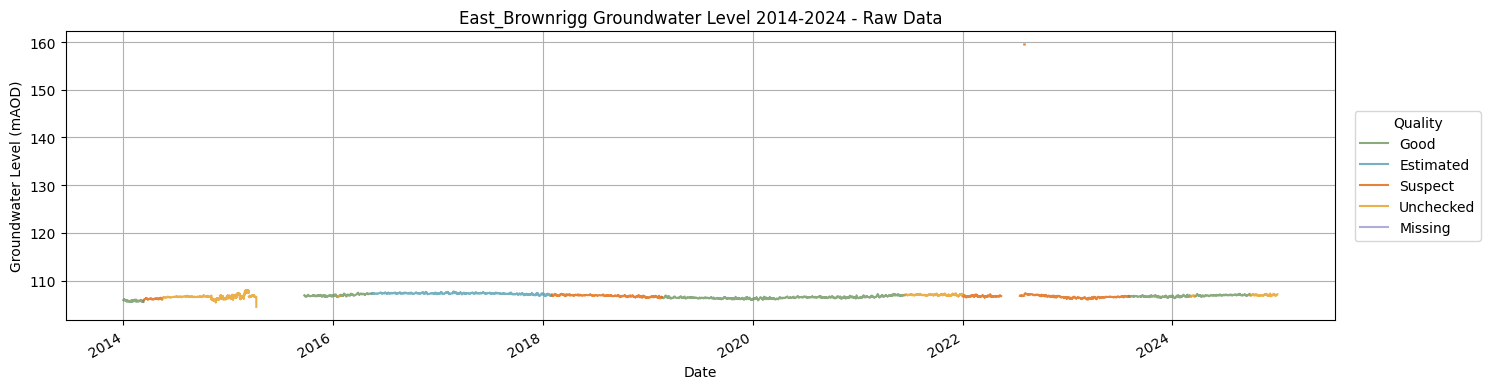

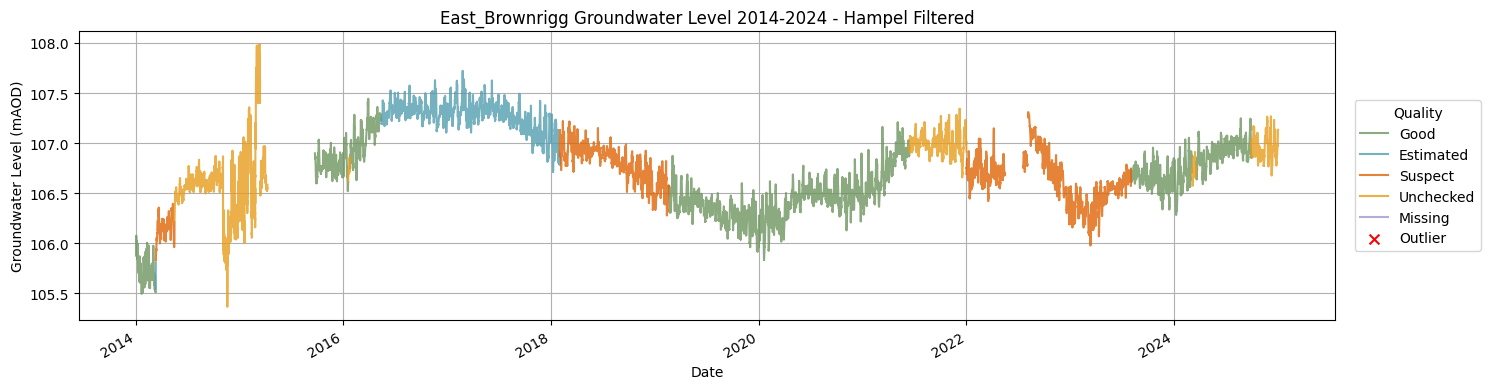

INFO - Processing 9 / 16: Bgs_Ev2...

INFO - No outliers to plot for station Bgs_Ev2
INFO - Station Bgs_Ev2: Hard limits 85.33 - 89.06
INFO - Station Bgs_Ev2: Identified 1174 points outsideIQR-based range and set to NaN.
INFO - Total 2 outliers detected and replaced by Hampel filter in 'Bgs_Ev2'.
INFO - Processing Bgs_Ev2 complete.



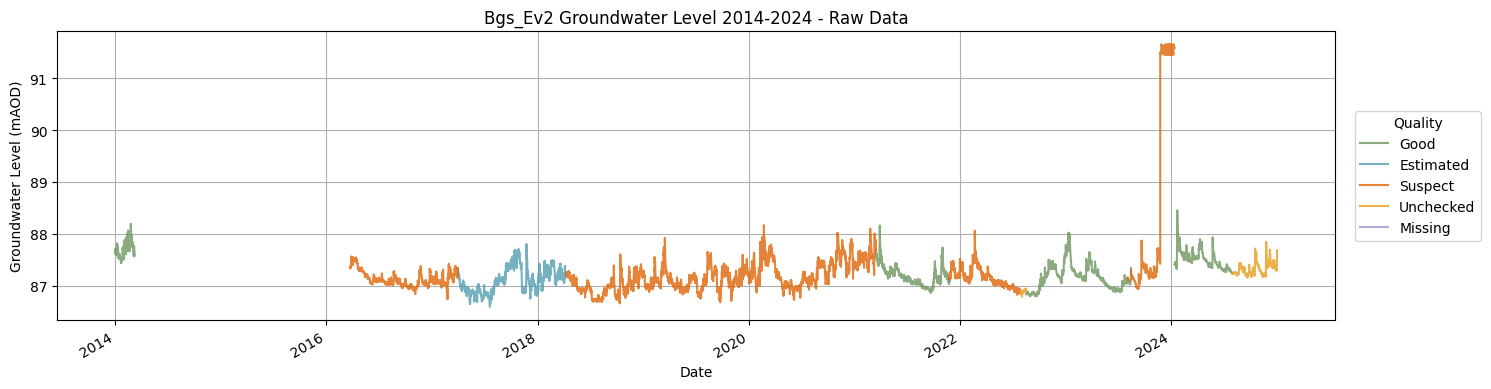

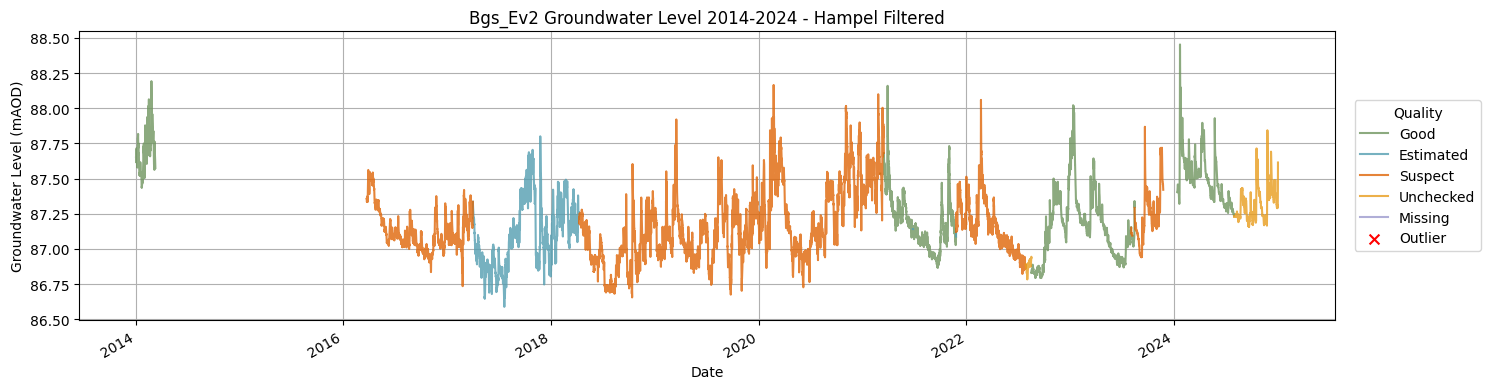

INFO - Processing 10 / 16: Skirwith...

INFO - No outliers to plot for station Skirwith
INFO - Station Skirwith: Hard limits 127.49 - 134.00
INFO - Station Skirwith: No points out of range.
INFO - Total 0 outliers detected and replaced by Hampel filter in 'Skirwith'.
INFO - No outliers to plot for station Skirwith
INFO - Processing Skirwith complete.



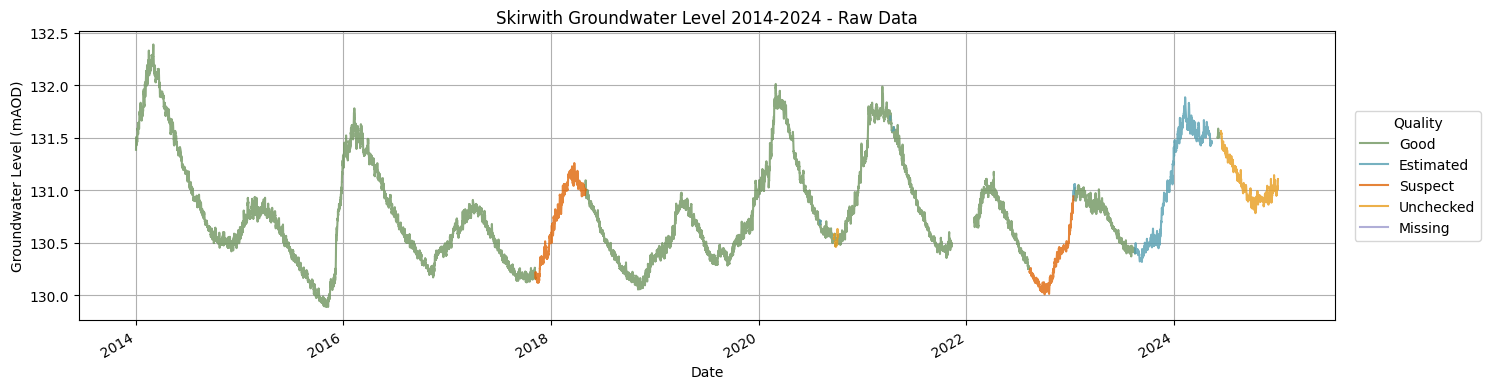

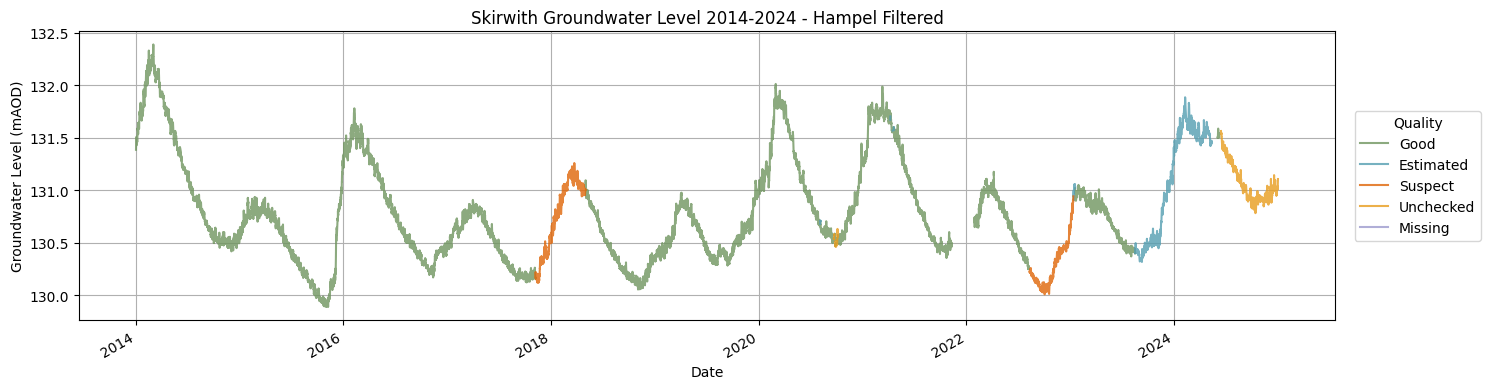

INFO - Processing 11 / 16: Cliburn_Town_Bridge_1...

INFO - No outliers to plot for station Cliburn_Town_Bridge_1
INFO - Station Cliburn_Town_Bridge_1: Hard limits 109.03 - 111.32
INFO - Station Cliburn_Town_Bridge_1: Identified 49 points outsideIQR-based range and set to NaN.
INFO - Total 0 outliers detected and replaced by Hampel filter in 'Cliburn_Town_Bridge_1'.
INFO - No outliers to plot for station Cliburn_Town_Bridge_1
INFO - Processing Cliburn_Town_Bridge_1 complete.



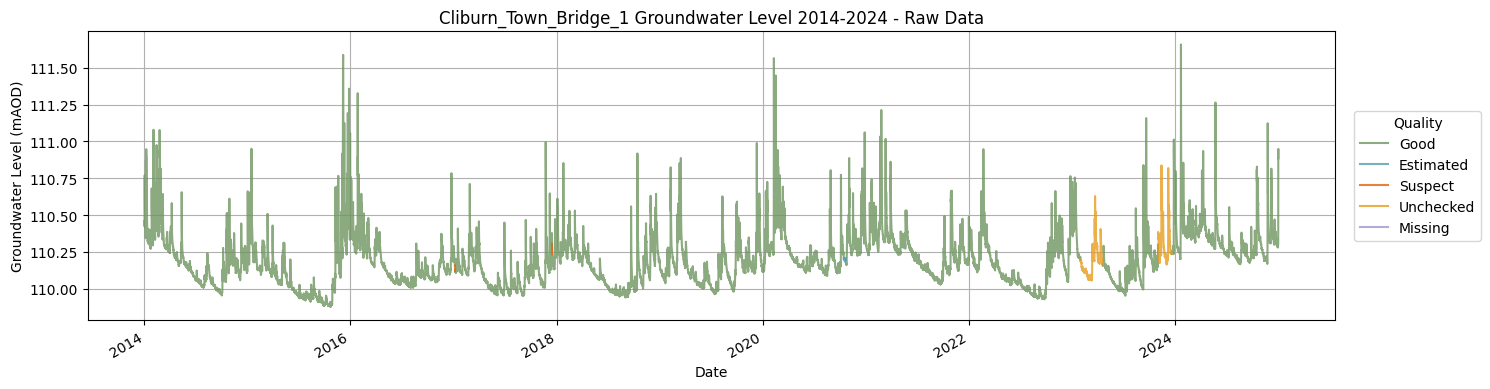

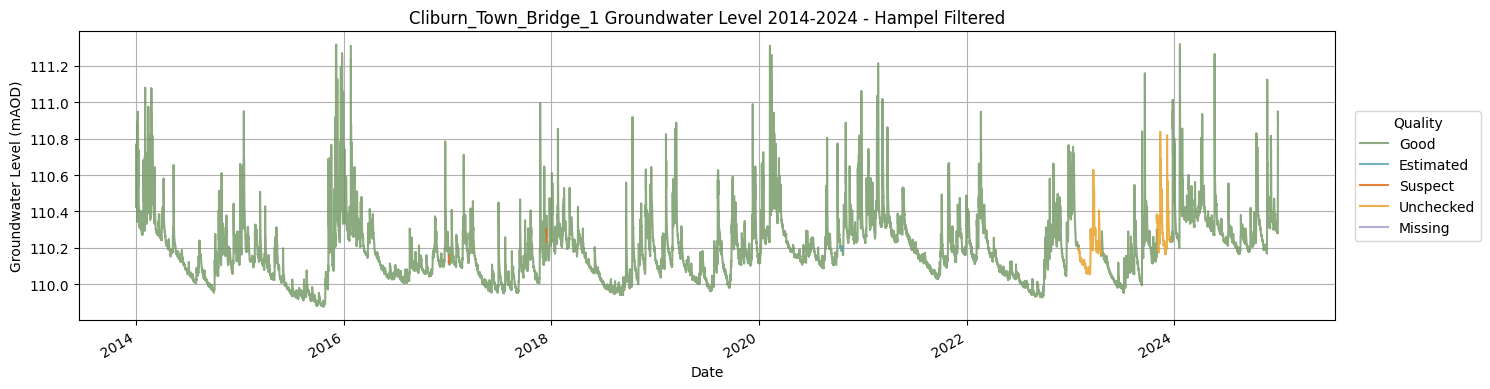

INFO - Processing 12 / 16: Cliburn_Town_Bridge_2...

INFO - No outliers to plot for station Cliburn_Town_Bridge_2
INFO - Station Cliburn_Town_Bridge_2: Hard limits 109.22 - 112.37
INFO - Station Cliburn_Town_Bridge_2: No points out of range.
INFO - Total 0 outliers detected and replaced by Hampel filter in 'Cliburn_Town_Bridge_2'.
INFO - No outliers to plot for station Cliburn_Town_Bridge_2
INFO - Processing Cliburn_Town_Bridge_2 complete.



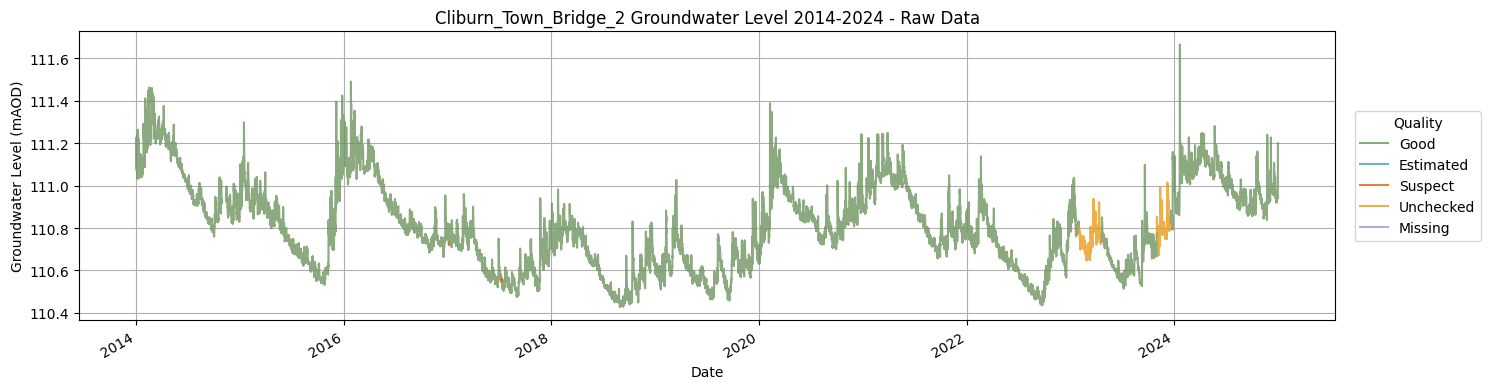

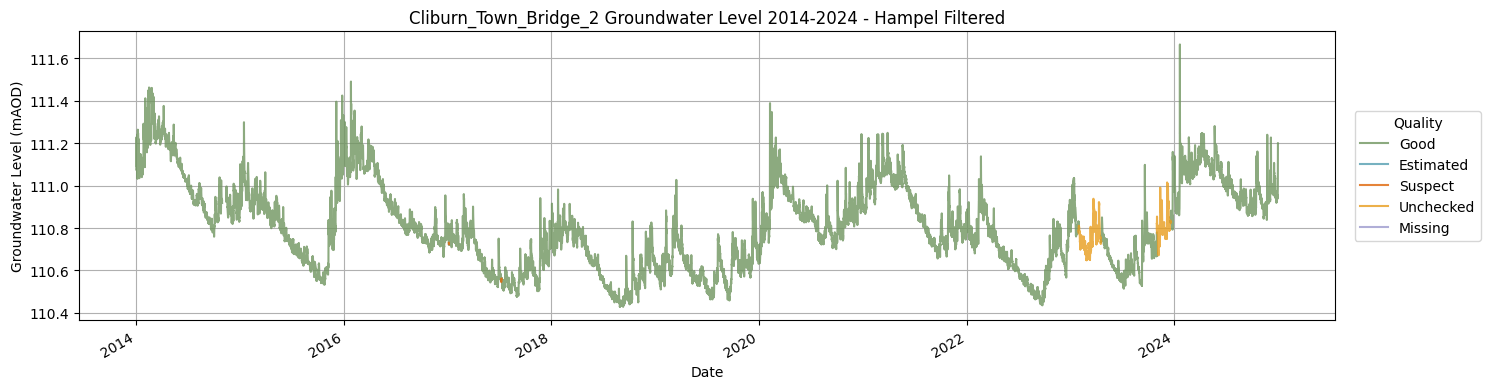

INFO - Processing 13 / 16: Hilton...

INFO - No outliers to plot for station Hilton
INFO - Station Hilton: Hard limits 206.56 - 222.77
INFO - Station Hilton: No points out of range.
INFO - Total 78 outliers detected and replaced by Hampel filter in 'Hilton'.
INFO - Processing Hilton complete.



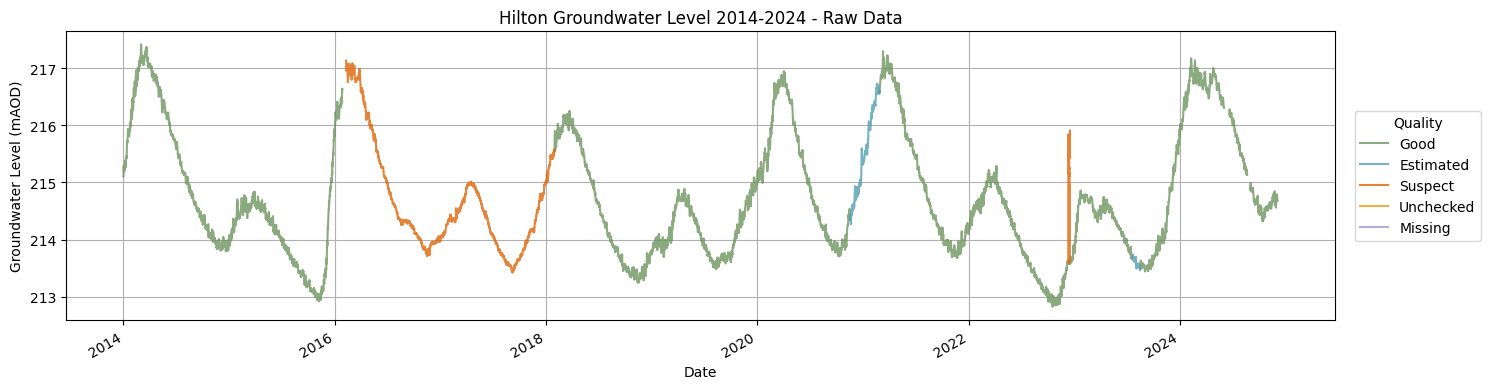

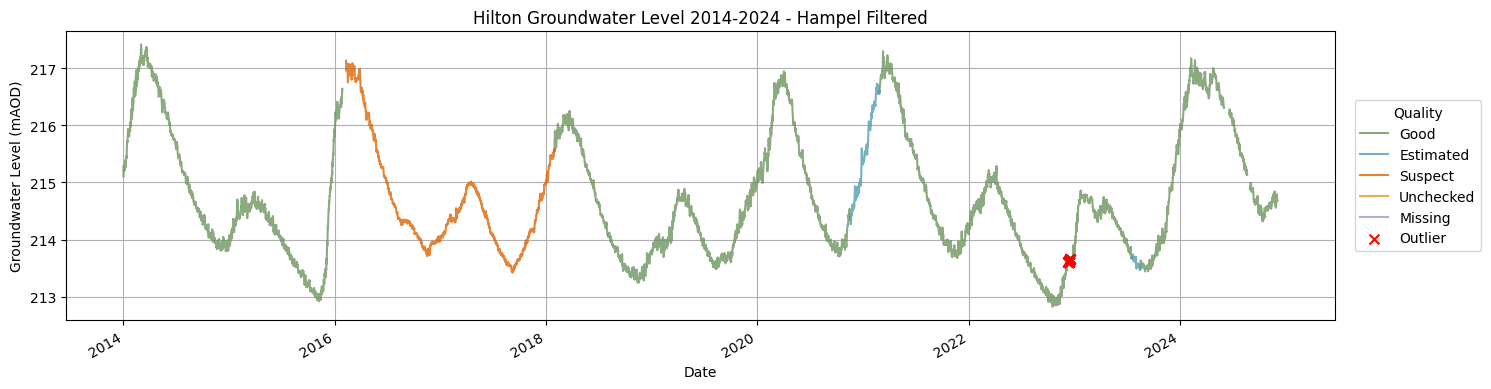

INFO - Processing 14 / 16: Coupland...

INFO - No outliers to plot for station Coupland
INFO - Station Coupland: Hard limits 133.92 - 137.40
INFO - Station Coupland: No points out of range.
INFO - Total 0 outliers detected and replaced by Hampel filter in 'Coupland'.
INFO - No outliers to plot for station Coupland
INFO - Processing Coupland complete.



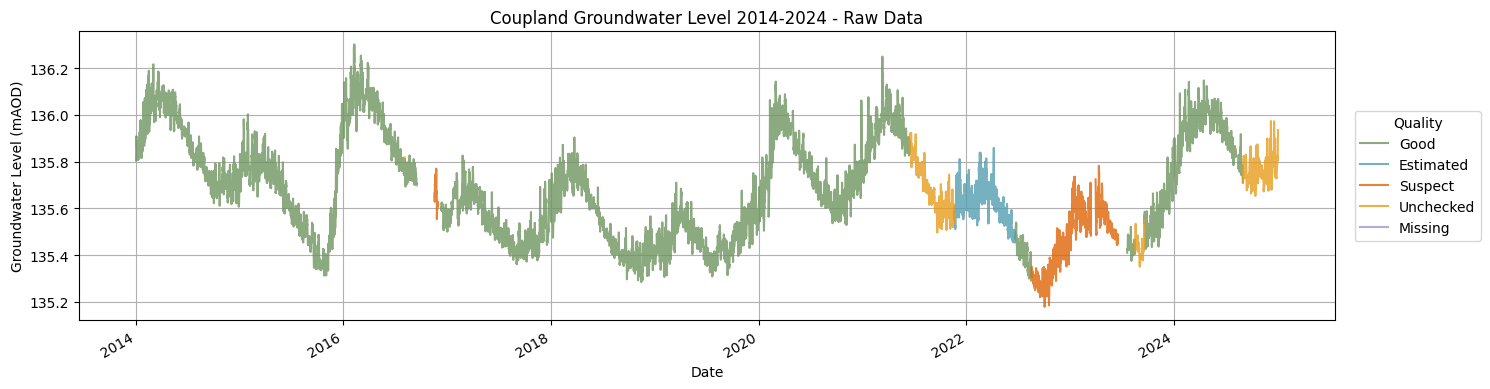

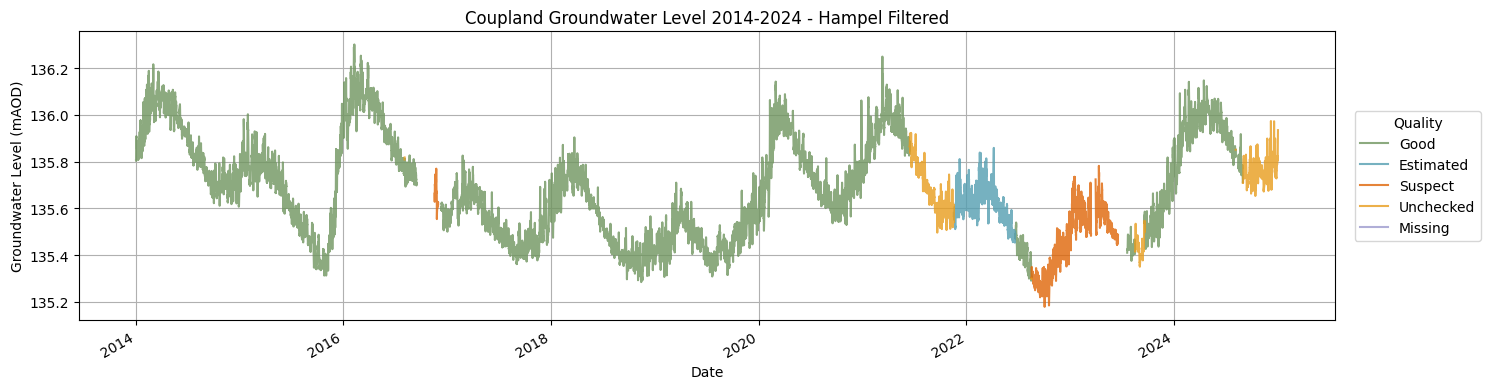

INFO - Processing 15 / 16: Great_Musgrave...

INFO - No outliers to plot for station Great_Musgrave
INFO - Station Great_Musgrave: Hard limits 148.78 - 155.59
INFO - Station Great_Musgrave: No points out of range.
INFO - Total 0 outliers detected and replaced by Hampel filter in 'Great_Musgrave'.
INFO - No outliers to plot for station Great_Musgrave
INFO - Processing Great_Musgrave complete.



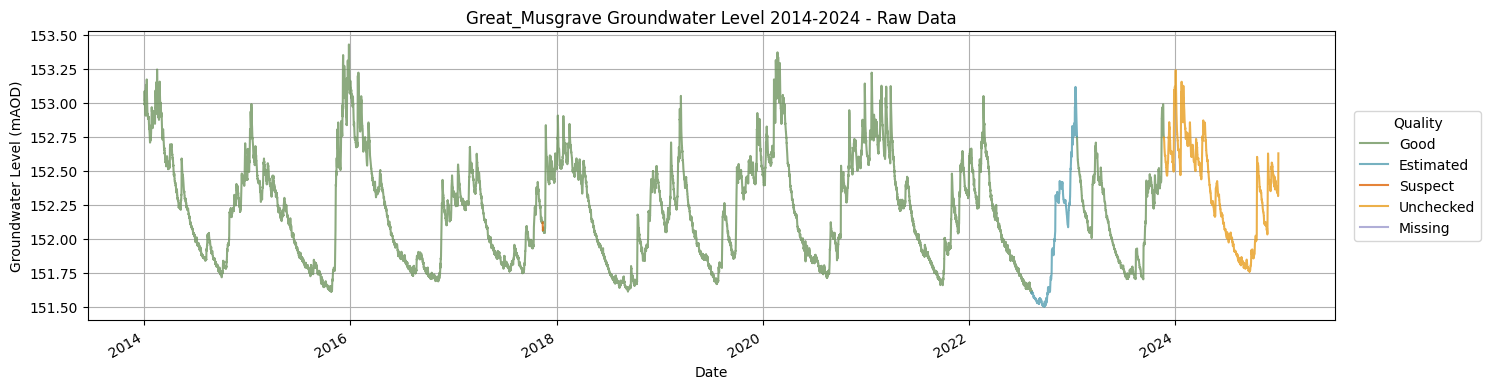

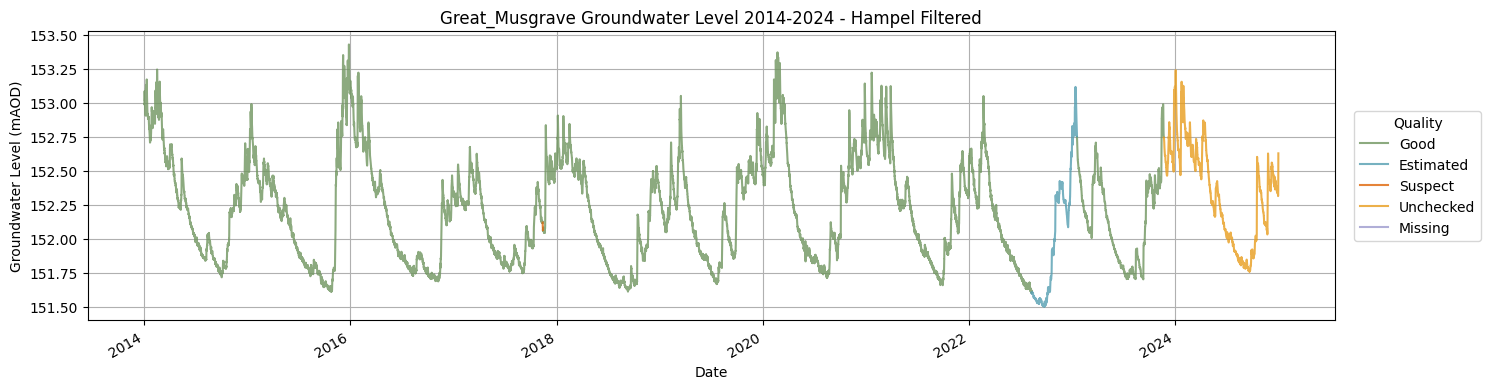

INFO - Processing 16 / 16: East_Curthwaite...

INFO - No outliers to plot for station East_Curthwaite
INFO - Station East_Curthwaite: Hard limits 36.94 - 41.40
INFO - Station East_Curthwaite: No points out of range.
INFO - Total 10 outliers detected and replaced by Hampel filter in 'East_Curthwaite'.
INFO - Processing East_Curthwaite complete.



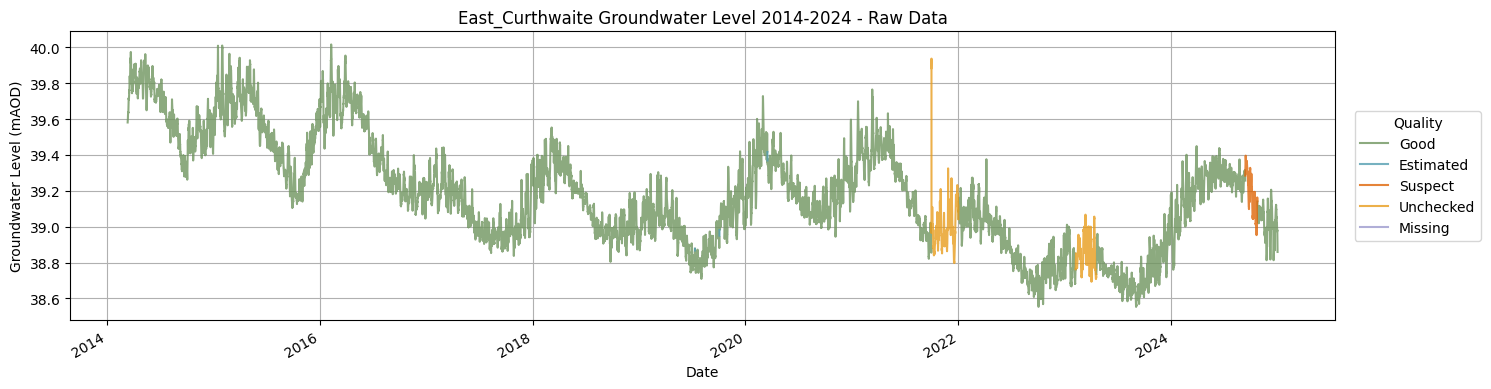

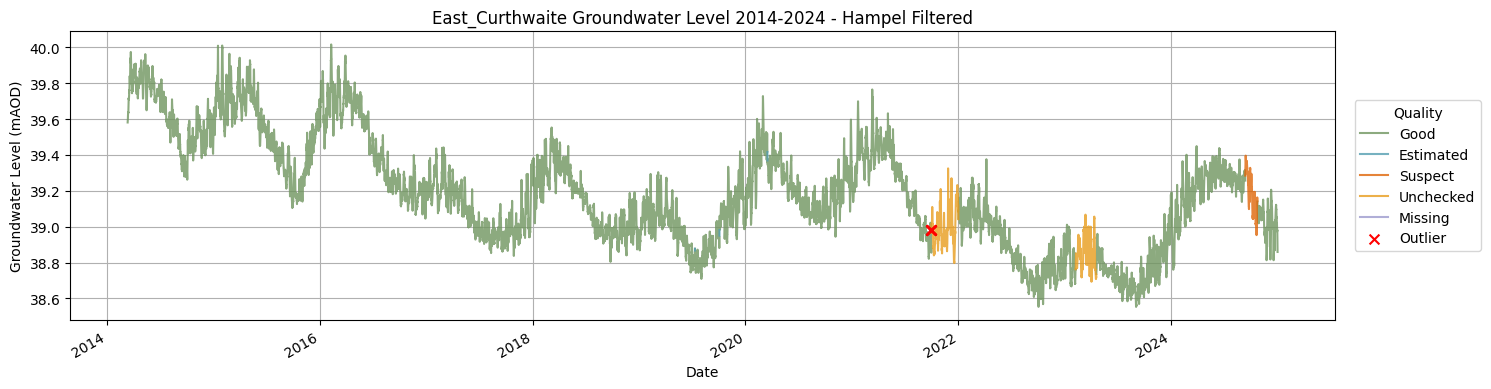

In [8]:
run_outlier_processing = False

if run_outlier_processing:
    # run outlier detection and processing
    processed_gwl_time_series_dict = outlier_detection(
        gwl_time_series_dict=gwl_time_series_dict,
        output_path=config[catchment]["visualisations"]["ts_plots"]["time_series_gwl_output"],
        dpi=config[catchment]["visualisations"]["ts_plots"]["dpi_save"],
        dict_output=config[catchment]["paths"]["gwl_outlier_dict"],
        notebook=True
    )

3. Aggregate to daily time steps

INFO - Initalising resampling of gwl data to daily timestep.

INFO - Resampling Longtown to daily timestep...
INFO -     Longtown resampled -> now contains 3987 non-zero data points.
INFO -     Data covers 99.2% of time period.

INFO - Resampling Scaleby to daily timestep...
INFO -     Scaleby resampled -> now contains 3743 non-zero data points.
INFO -     Data covers 93.1% of time period.

INFO - Resampling Castle_Carrock to daily timestep...
INFO -     Castle_Carrock resampled -> now contains 3863 non-zero data points.
INFO -     Data covers 96.1% of time period.

INFO - Resampling Croglin to daily timestep...
INFO -     Croglin resampled -> now contains 3806 non-zero data points.
INFO -     Data covers 94.7% of time period.

INFO - Resampling Ainstable to daily timestep...
INFO -     Ainstable resampled -> now contains 4003 non-zero data points.
INFO -     Data covers 99.6% of time period.

INFO - Resampling Baronwood to daily timestep...
INFO -     Baronwood resampled -> now contai

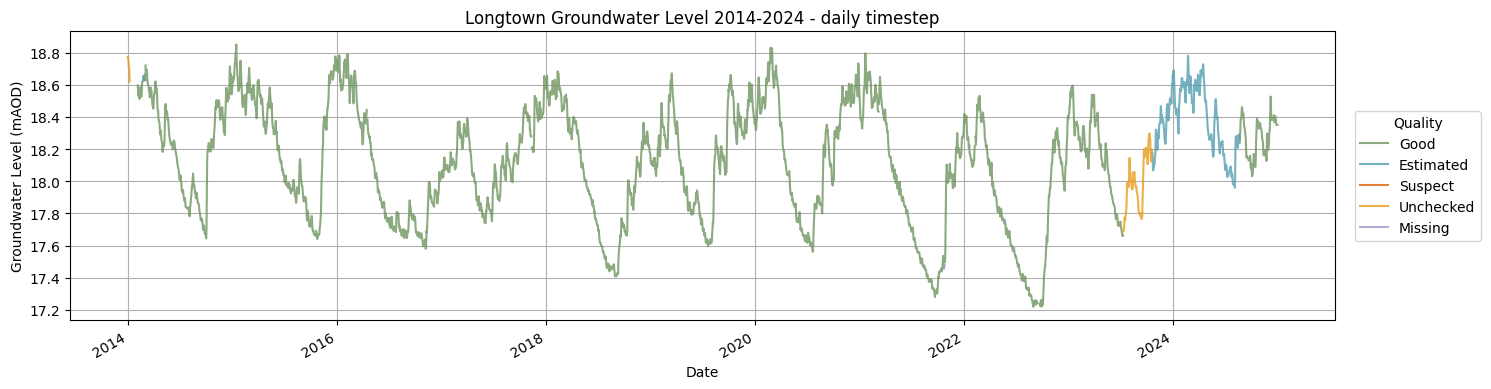

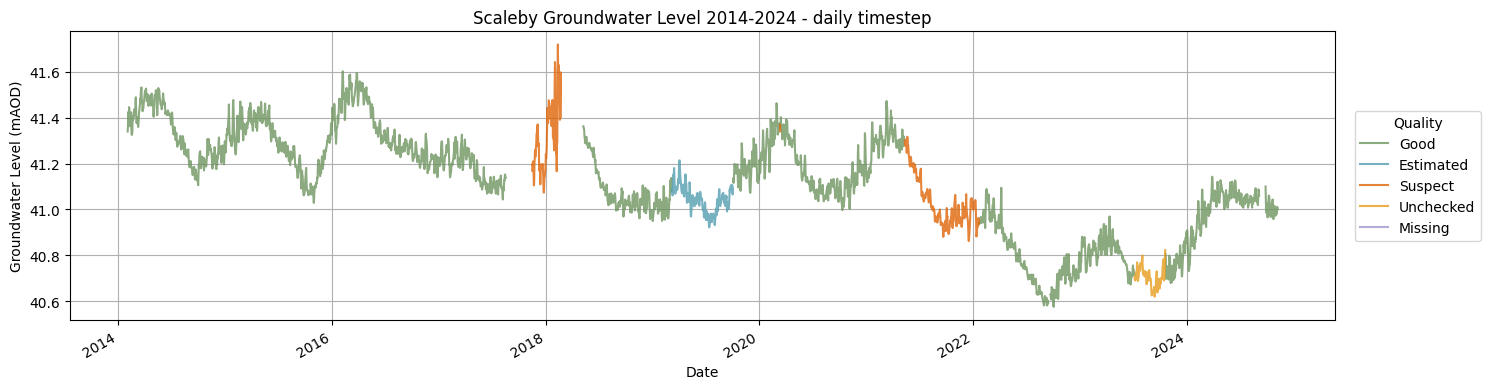

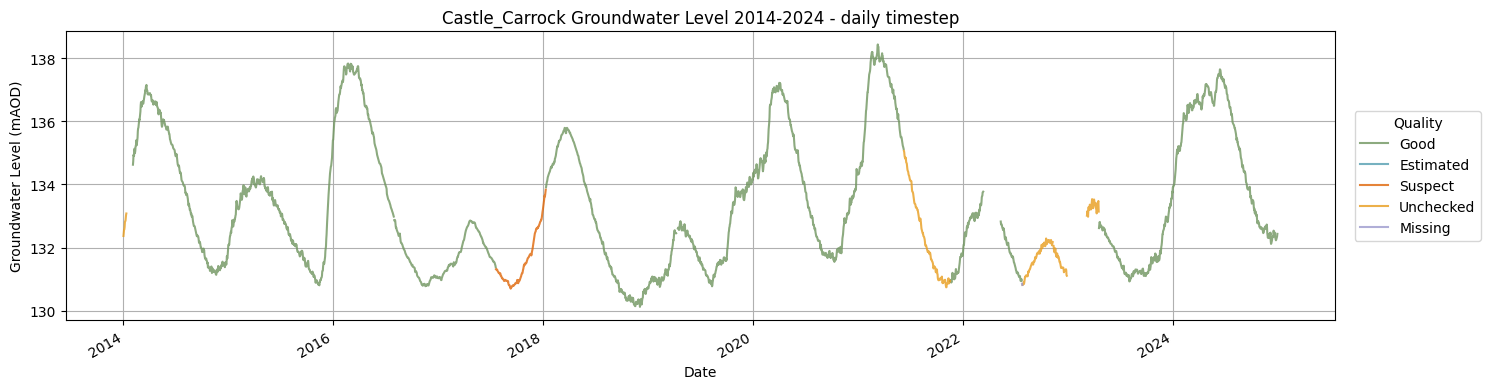

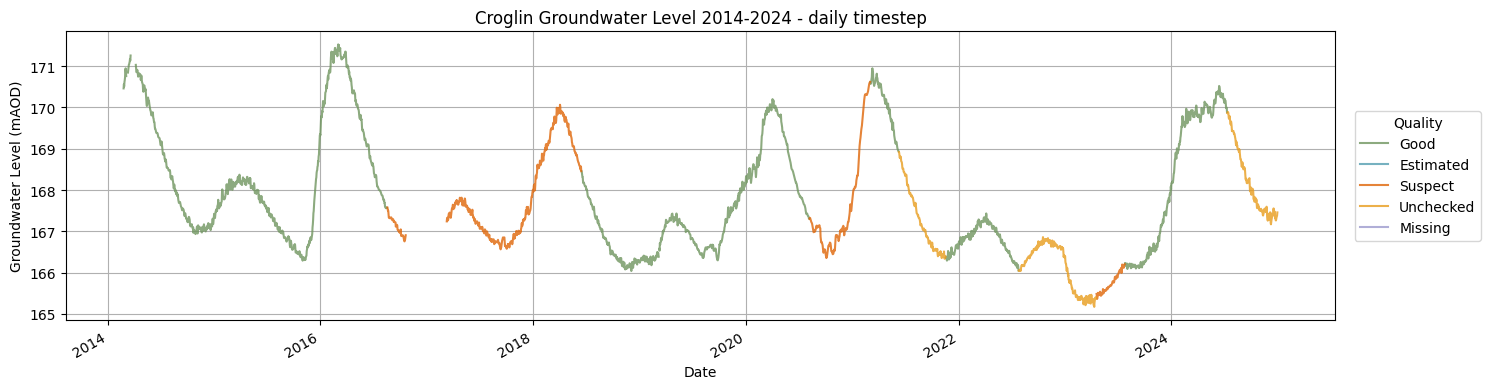

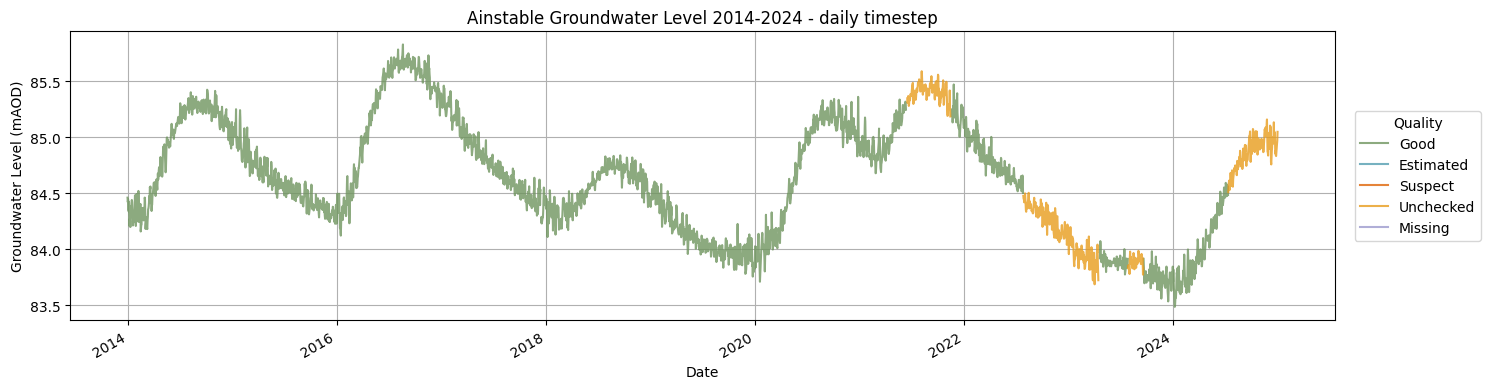

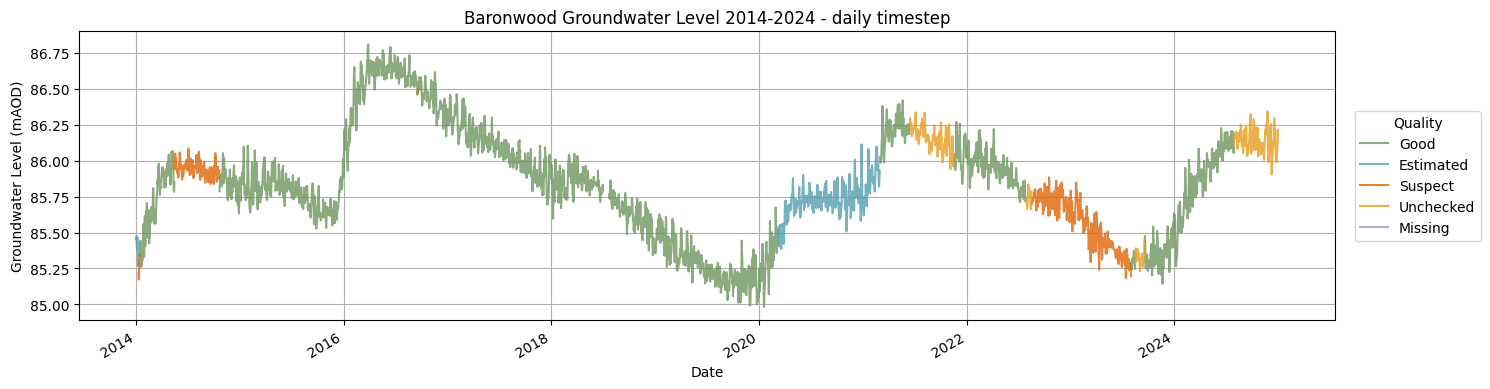

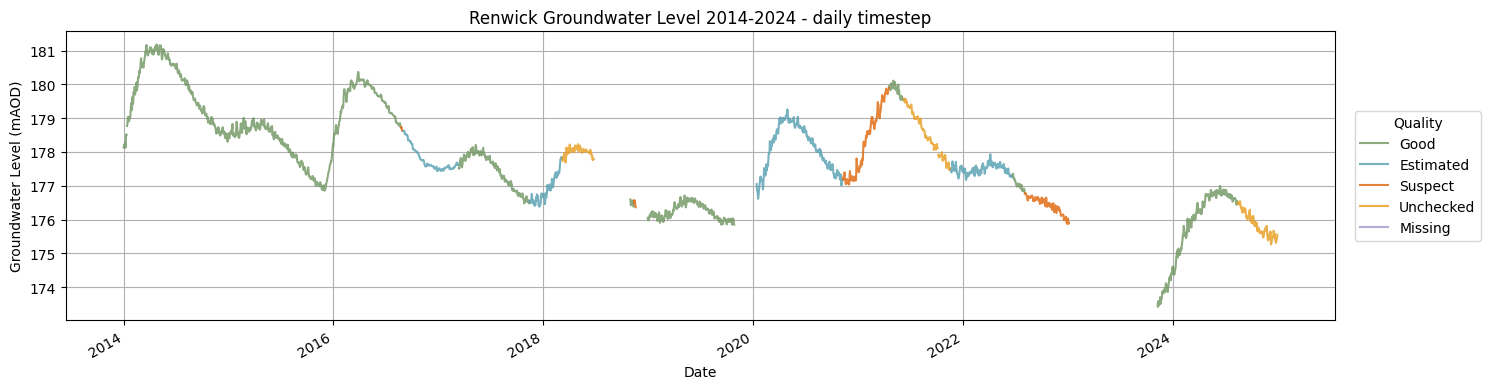

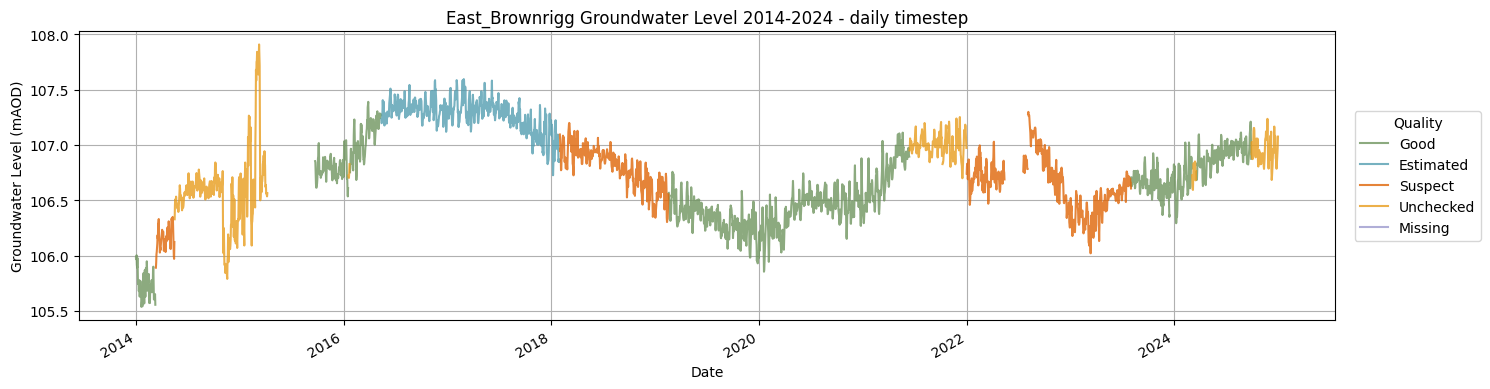

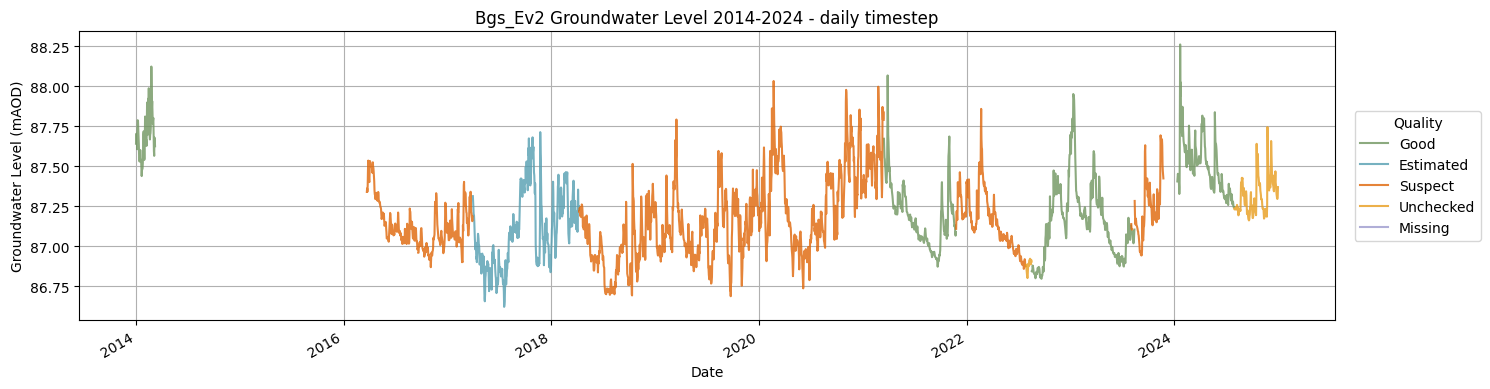

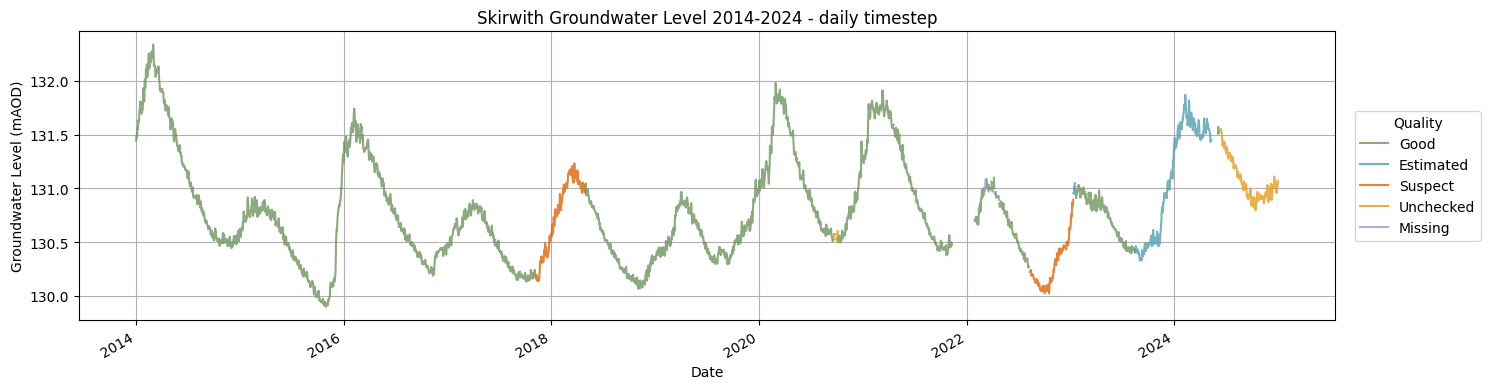

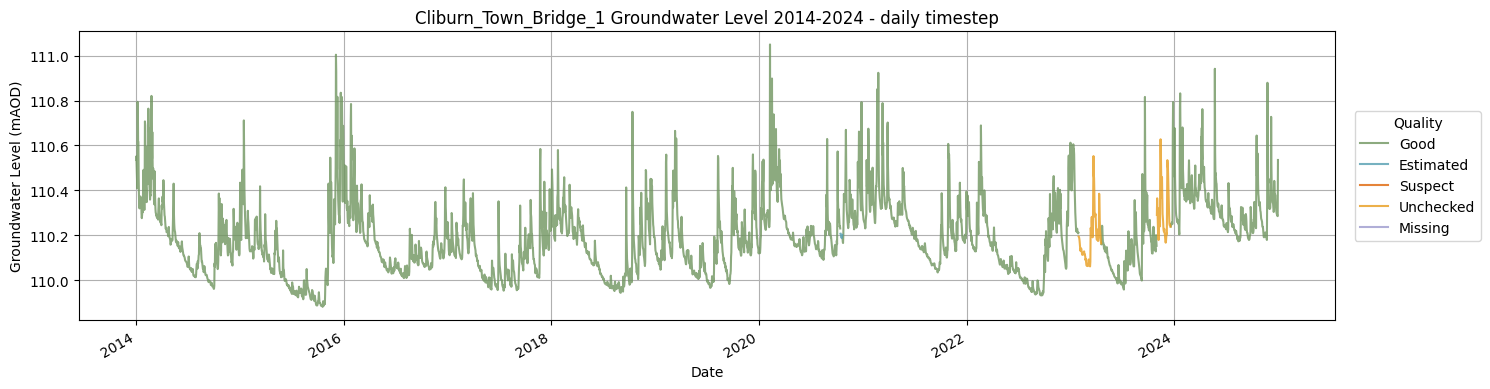

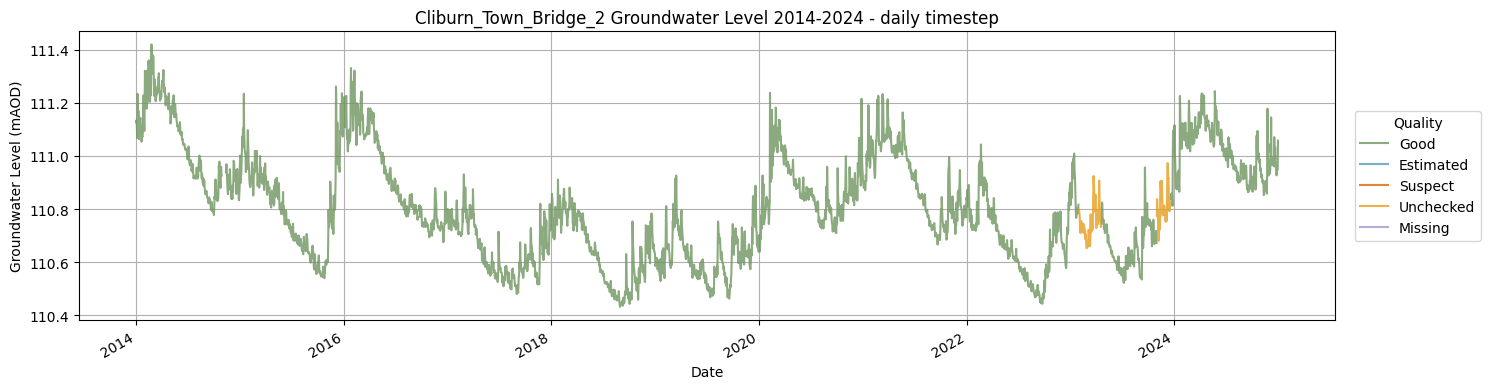

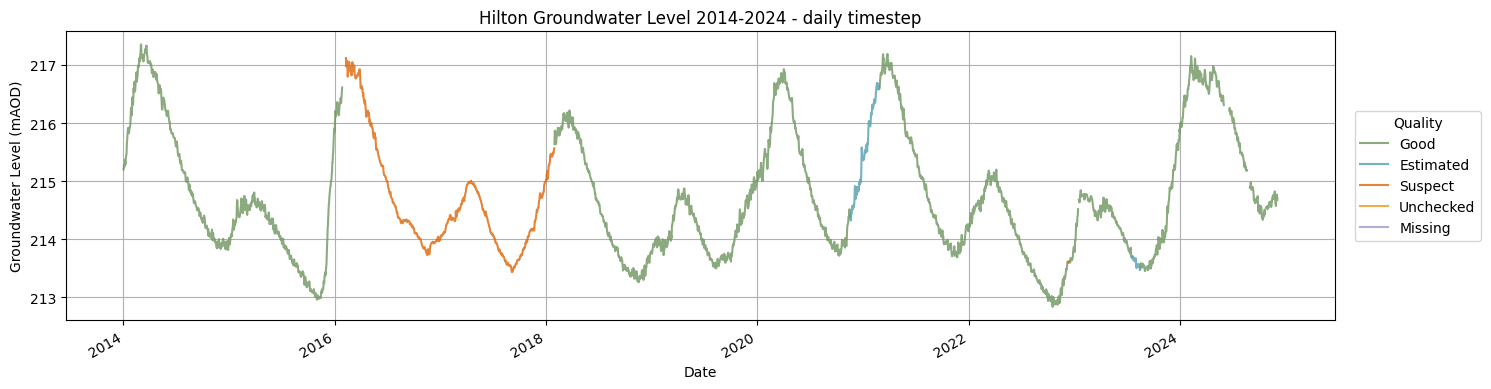

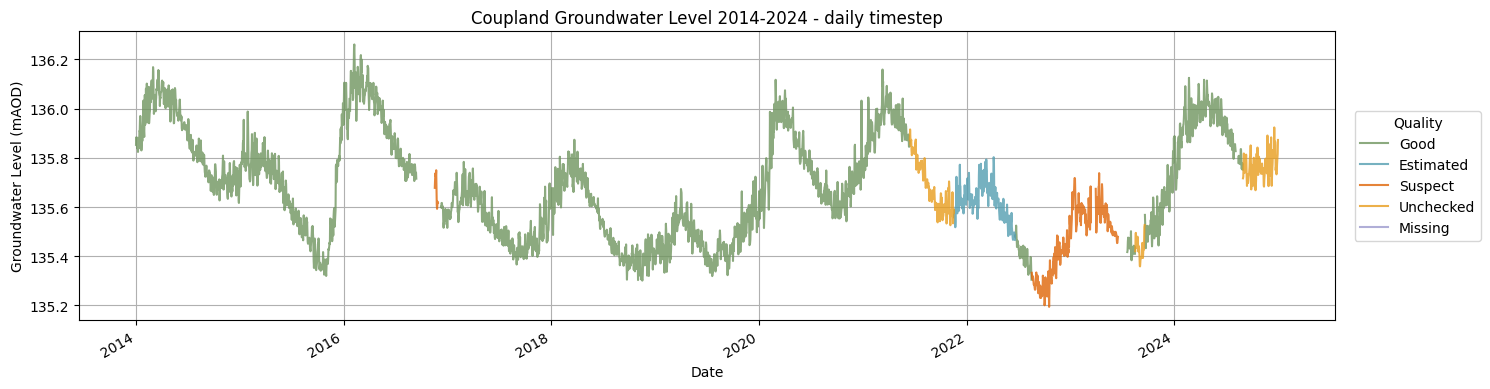

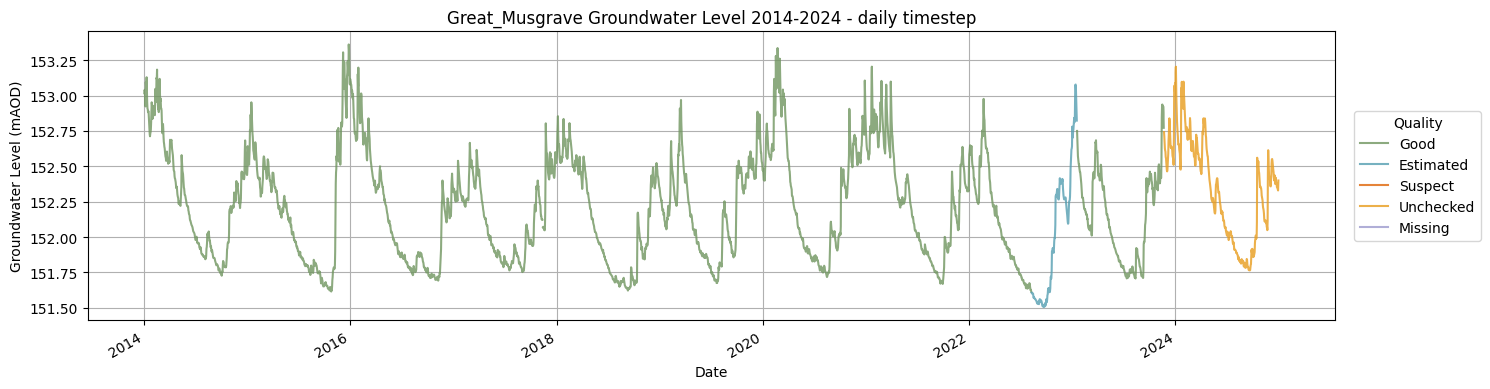

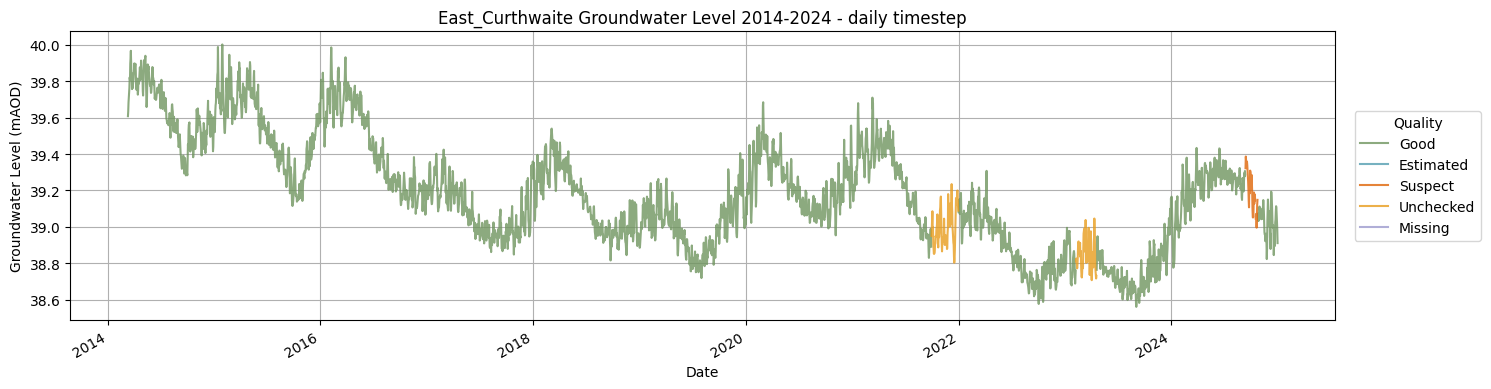

In [9]:
if not run_outlier_processing:
    input_dict = config[catchment]["paths"]["gwl_outlier_dict"]
    processed_gwl_time_series_dict = joblib.load(input_dict)

daily_data = resample_daily_average(
    dict=processed_gwl_time_series_dict,
    start_date=config["global"]["data_ingestion"]["api_start_date"],
    end_date=config["global"]["data_ingestion"]["api_end_date"],
    path=config[catchment]["visualisations"]["ts_plots"]["time_series_gwl_output"],
    notebook=True
)

4. Interpolate across small gaps in the ts data using rational spline or PCHIP - try both (& define threshold n/o missing time steps for interpolation eligibility) + Add binary interpolation flag column

Longtown contains 32 missing data points across 3 gaps.

    Gap 1: 25 data points (interpolate)
    Gap 2: 6 data points (interpolate)
    Gap 3: 1 data points (interpolate)
INFO - Longtown: Total interpolated points = 31
------------------------------------------------------------

INFO - Longtown updated plot saved to results/figures/eden/time_series/Longtown_aggregated_daily.png
Scaleby contains 276 missing data points across 6 gaps.

    Gap 1: 33 data points (interpolate)
    Gap 2: 87 data points (do not interpolate)
    Gap 3: 74 data points (do not interpolate)
    Gap 4: 6 data points (interpolate)
    Gap 5: 20 data points (interpolate)
    Gap 6: 56 data points (do not interpolate)
INFO - Scaleby: Total interpolated points = 26
------------------------------------------------------------

INFO - Scaleby updated plot saved to results/figures/eden/time_series/Scaleby_aggregated_daily.png
Castle_Carrock contains 156 missing data points across 7 gaps.

    Gap 1: 22 data points

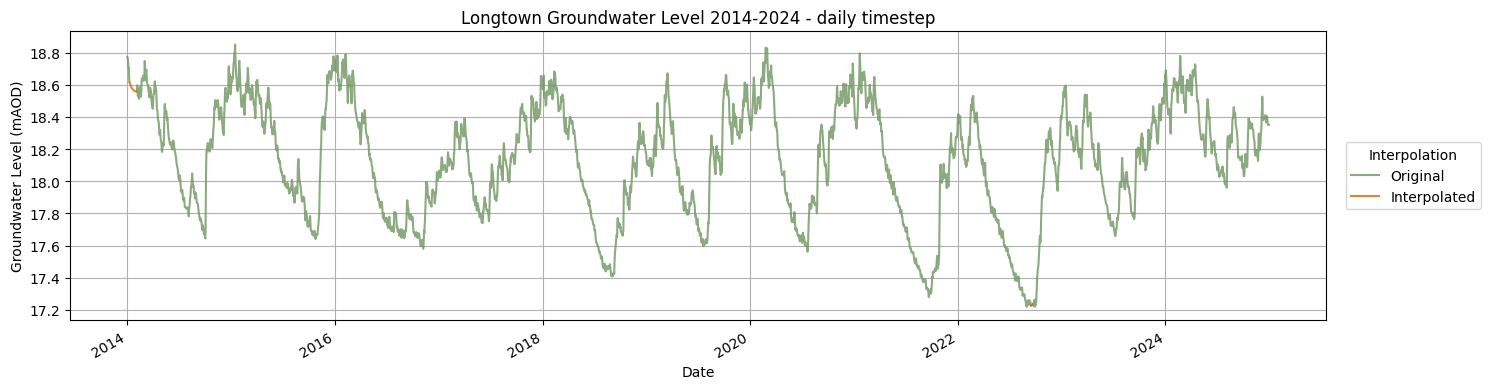

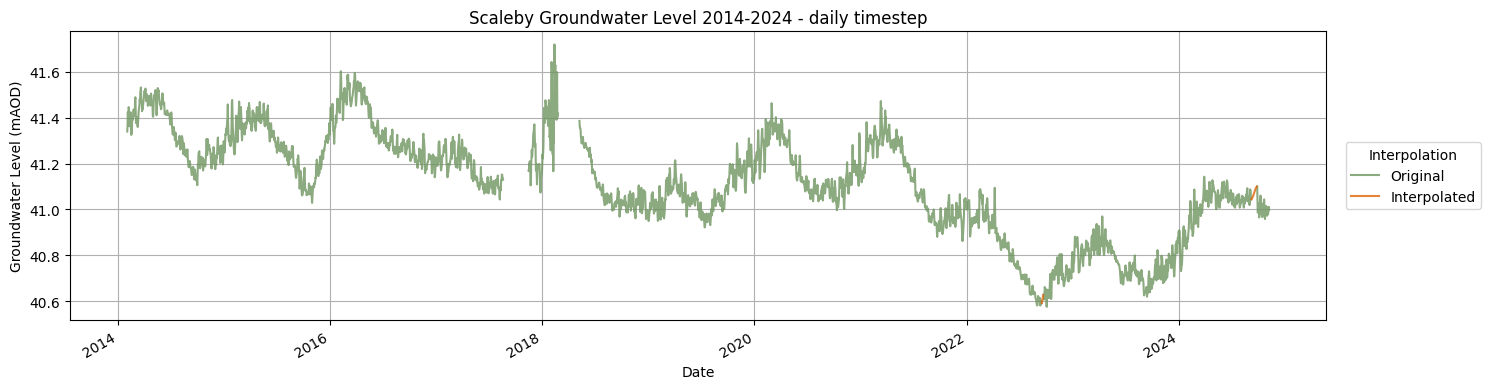

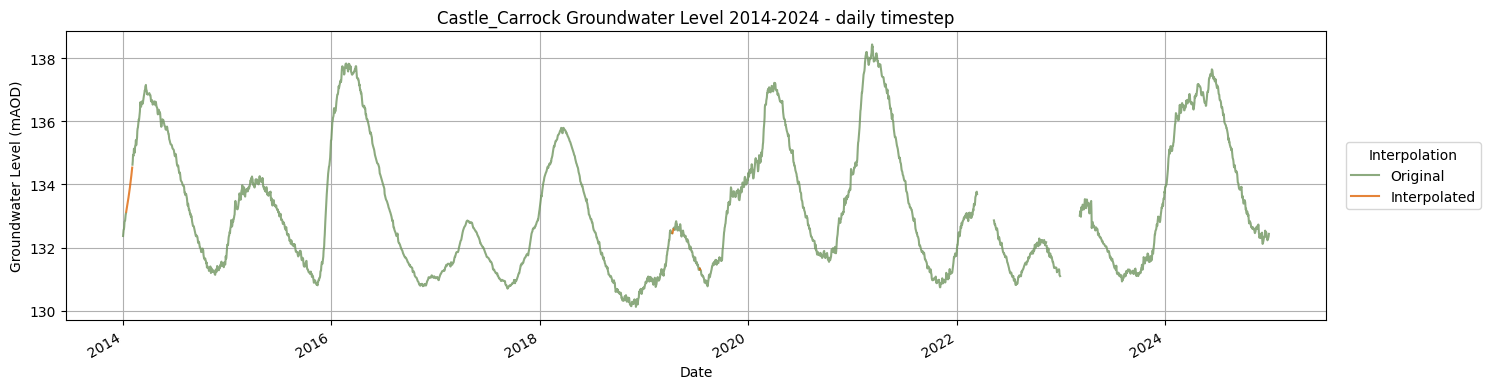

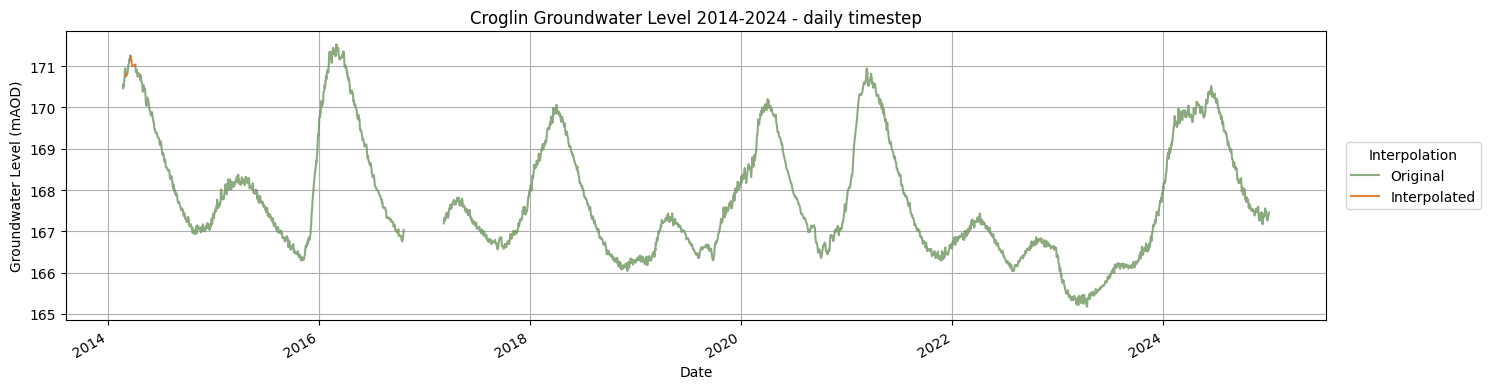

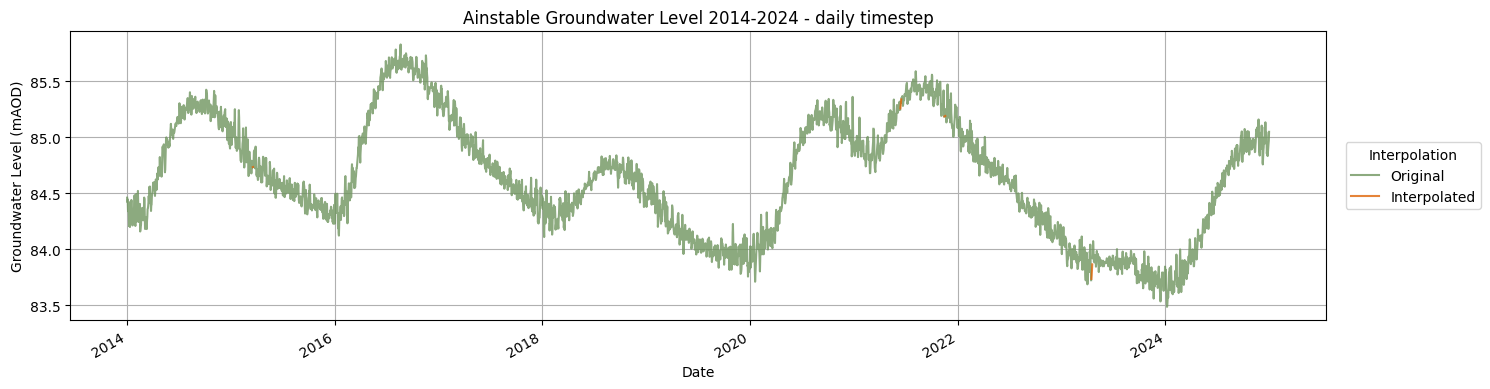

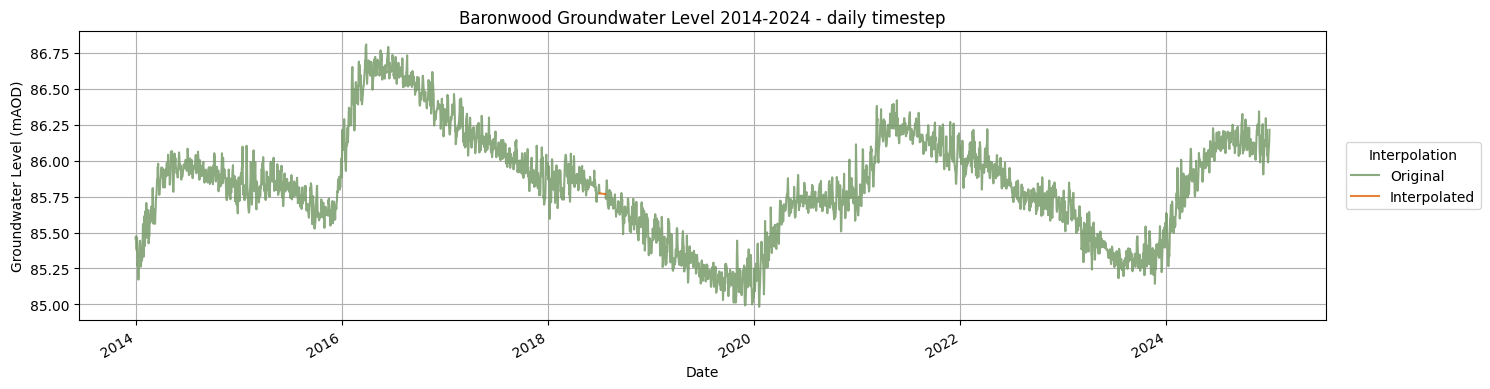

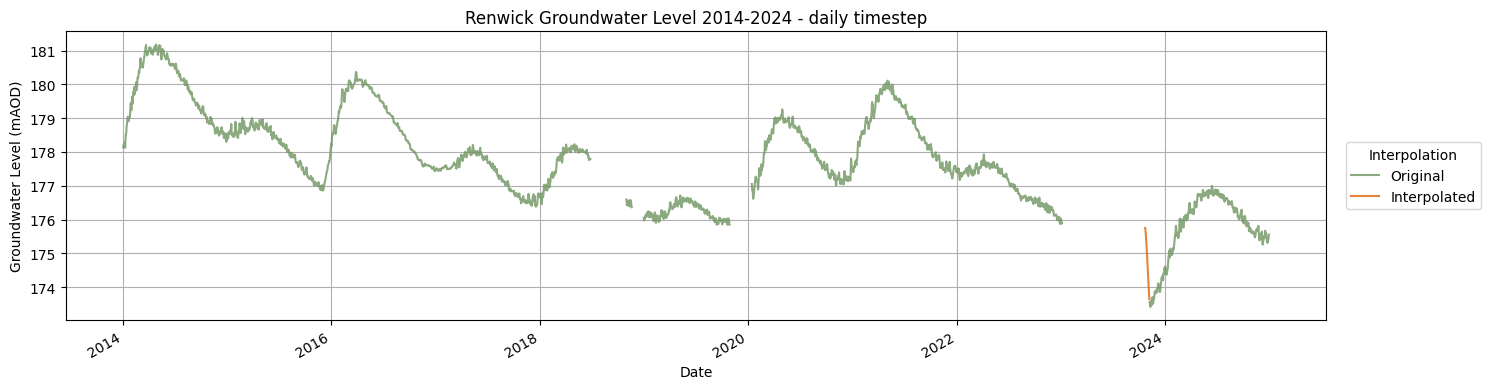

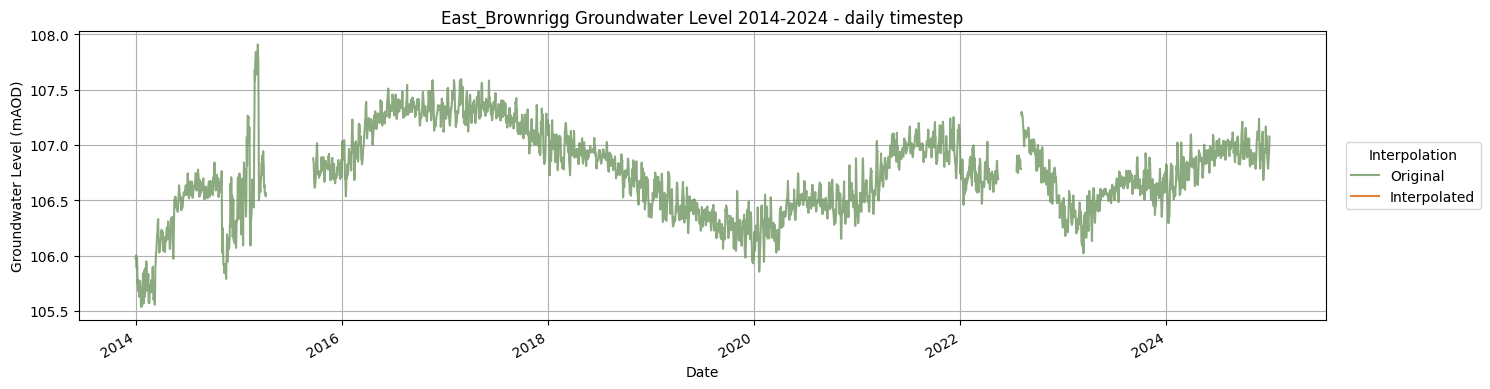

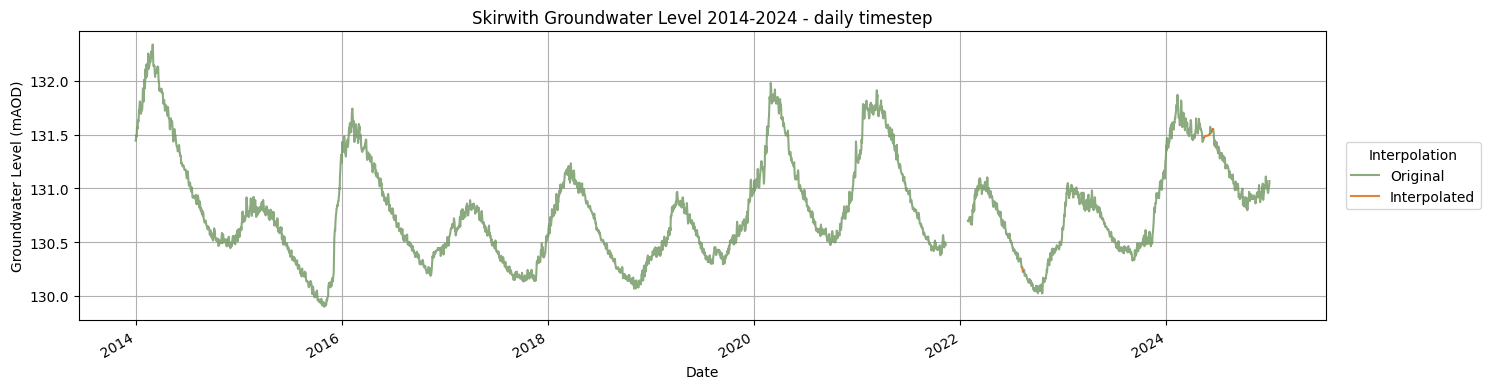

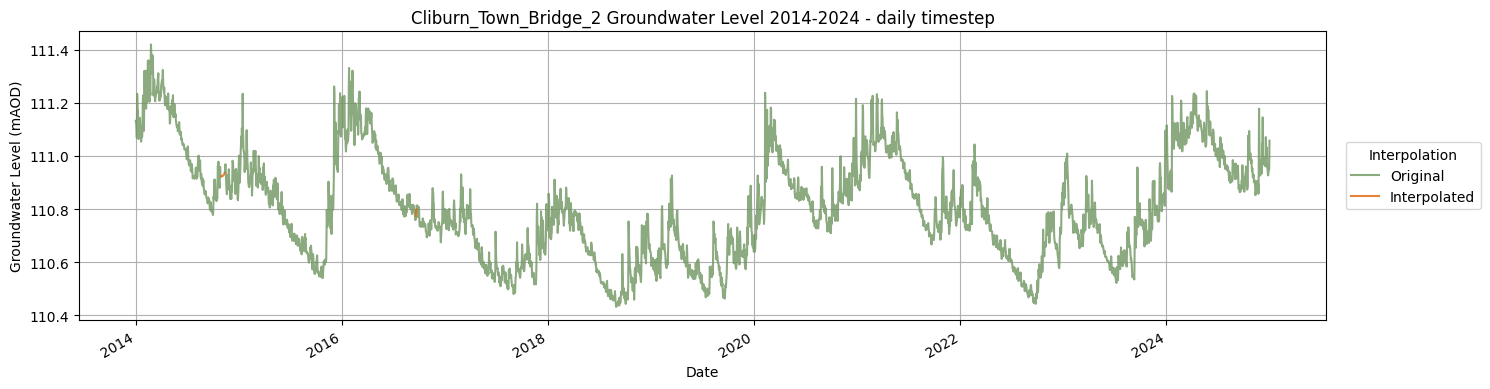

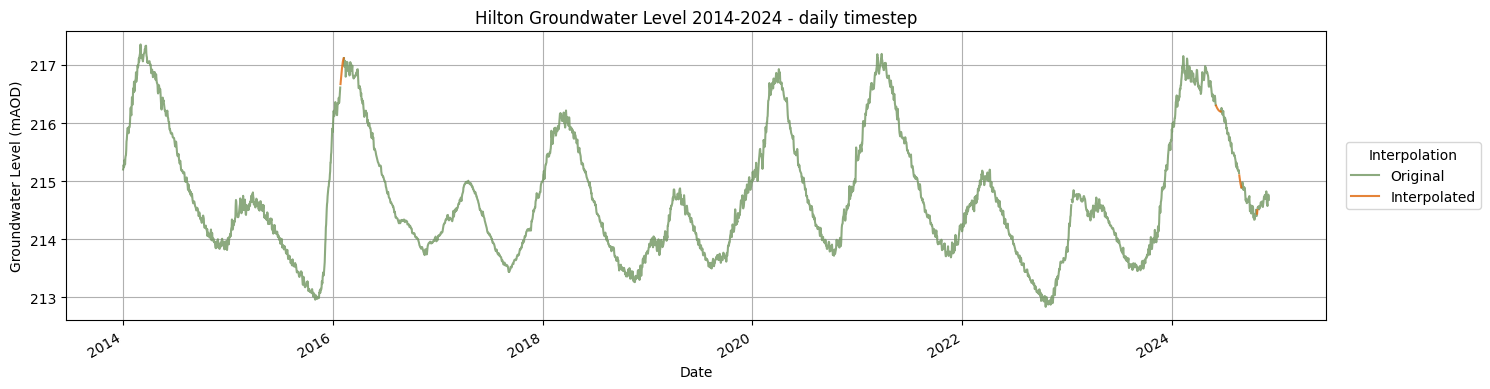

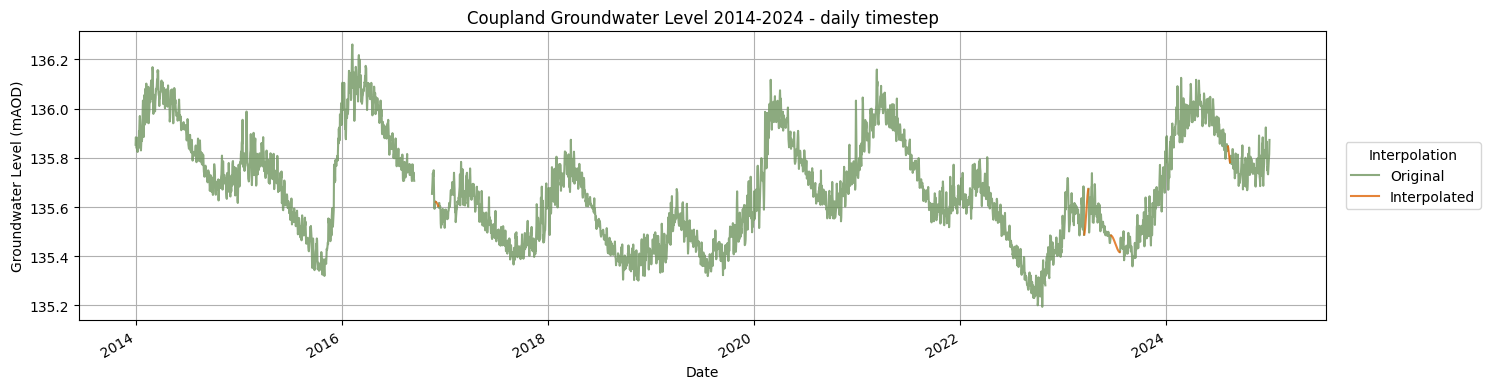

In [10]:
for station_name, df in daily_data.items():
    daily_data[station_name] = interpolate_short_gaps(
        df=df,
        station_name=station_name,
        path=config[catchment]["visualisations"]["ts_plots"]["time_series_gwl_output"],
        max_steps=config["global"]["data_ingestion"]["max_interp_length"],
        notebook=True
    )

Handle large gaps

In [11]:
handle_large_gaps(
    df=daily_data,
    catchment=catchment,
    spatial_path=config[catchment]["paths"]["gwl_station_list_with_coords"],
    path=config[catchment]["visualisations"]["ts_plots"]["time_series_gwl_output"],
    threshold_m=config[catchment]["preprocessing"]["large_catchment_threshold_m"],
    radius=config["global"]["preprocessing"]["radius"],
    notebook=True
)

INFO - Checking if eden is a large catchment...

INFO - eden easting_range_m: 44350.0
INFO - eden northing_range_m: 54590.0

INFO - Large Catchment?: True (threshold: 50000m)

INFO - eden: Distance matrix calculated using Haversine method.



5. Lagged: Add lagged features (by timestep across 7 days?) + potentially rolling averages (3-day/7-day?)

6. Temporal Encoding: Define sinasoidal features for seasonality (both sine and cosine for performance)

To zoom in on an area of a graph:

In [13]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import pandas as pd

# start_date = '2022-12-01'
# end_date = '2023-12-31'

# # Filter the DataFrame
# df_renwick = daily_data['Ainstable']
# df_renwick['dateTime'] = pd.to_datetime(df_renwick['dateTime'], errors='coerce')
# filtered_df_renwick = df_renwick[(df_renwick['dateTime'] >= start_date) & (df_renwick['dateTime'] <= end_date)]

# # print(filtered_df_renwick.head(20))

# fig, ax = plt.subplots(figsize=(12, 6)) # Use fig, ax for more control

# ax.plot(filtered_df_renwick['dateTime'], filtered_df_renwick['value'])
# ax.set_title(f"Renwick Groundwater Level: {start_date} to {end_date}")
# ax.set_xlabel("Date")
# ax.set_ylabel("Groundwater Level (mAOD)")

# ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))
# ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
# ax.grid(True, which='major', linestyle='-', linewidth=0.5)
# ax.grid(True, which='minor', linestyle=':', linewidth=0.2) # Finer, dashed minor grid


# fig.autofmt_xdate() # Auto-formats date labels for readability
# plt.show()

# # print(filtered_df.head())